In [1]:
## libraries
import os
from dotenv import load_dotenv
import psycopg2
import psycopg2.extras as extras
import pandas as pd
import numpy as np

## visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

## ML Libraries
from catboost import CatBoostRegressor,Pool
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit

## Error metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

## Parameter Optimization
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

## utilities
import feature_extraction
import weather_api

## Warnings
import warnings
warnings.filterwarnings("ignore")

## Settings
### Tunahanın ev
lat = 36.929517
lon = 30.663494

C:\Users\TolgaKurt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## DB Insert function
def execute_values(conn, df, table):

    tuples = [tuple(x) for x in df.to_numpy()]

    cols = ','.join(list(df.columns))
    # SQL query to execute
    query = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("the dataframe is inserted")
    cursor.close()

In [ ]:
# load .env file
load_dotenv()

DB_CONFIG = {
    "host": os.getenv("DB_HOST"),
    "port": os.getenv("DB_PORT"),
    "name": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USER"),
    "password": os.getenv("DB_PASSWORD")
}

connection = psycopg2.connect(
            database=DB_CONFIG["name"],
            user=DB_CONFIG["user"],
            password=DB_CONFIG["password"],
            host=DB_CONFIG["host"],
            port=DB_CONFIG["port"]
        )

## Query data from the database
data = pd.read_sql("SELECT * FROM public.weather_data_0001", connection)

In [4]:
## Load future weather data
## Settings start and end date. Start today, end today + 3 days
start = data["timestamp"].dt.date.max()
end = start + pd.Timedelta(days=3)
start_str = start.strftime('%Y-%m-%d')
end_str = end.strftime('%Y-%m-%d')

## Fetch future weather data from the API
future = weather_api.fetch_weather_data(lat, lon, start_str, end_str)

In [6]:
data = data[["timestamp","temperature","humidity","wind_speed","wind_direction","pressure","solar_radiation"]].copy()
data = feature_extraction.feature_engineering(data,future_data = future, drop_columns=["id"], resample_freq="H")
data = feature_extraction.add_meteo_features(data)
data = feature_extraction.add_advanced_features_with_lags(data)
data = feature_extraction.generate_features(data)
data

Dropped columns: ['id']


,timestamp,temperature,humidity,wind_speed,wind_direction,pressure,solar_radiation,wd_rad,wind_u,wind_v,...,lag_dew_point_3h,lag_dew_point_6h,lag_dew_point_12h,lag_dew_point_24h,lag_dewpoint_dep_1h,lag_dewpoint_dep_2h,lag_dewpoint_dep_3h,lag_dewpoint_dep_6h,lag_dewpoint_dep_12h,lag_dewpoint_dep_24h
0,2025-09-07 22:00:00+00:00,27.068000,71.356000,0.080000,278.520000,997.436000,0.0,4.861091,0.064225,-0.047698,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-09-07 23:00:00+00:00,26.861667,71.695833,0.175000,255.366667,997.221667,0.0,4.456989,0.089978,-0.139839,...,NaN,NaN,NaN,NaN,5.728800,NaN,NaN,NaN,NaN,NaN
2,2025-09-08 00:00:00+00:00,26.310000,72.752500,0.091667,277.875000,996.880000,0.0,4.849834,0.066852,-0.061346,...,NaN,NaN,NaN,NaN,5.660833,5.728800,NaN,NaN,NaN,NaN
3,2025-09-08 01:00:00+00:00,25.623333,73.805000,0.041667,314.616667,996.540833,0.0,5.491097,0.041636,0.001599,...,21.339200,NaN,NaN,NaN,5.449500,5.660833,5.728800,NaN,NaN,NaN
4,2025-09-08 02:00:00+00:00,25.606667,72.156667,0.000000,314.141667,995.999167,0.0,5.482806,0.000000,0.000000,...,21.200833,NaN,NaN,NaN,5.239000,5.449500,5.660833,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,2025-10-08 22:00:00+00:00,16.017000,85.000000,4.410215,3.900425,999.021790,0.0,0.068075,4.400000,0.299995,...,13.867000,14.117001,14.017000,17.567001,3.200000,3.400000,3.800000,7.6,5.0,3.0
745,2025-10-08 23:00:00+00:00,16.117001,84.000000,3.238827,8.880589,999.322205,0.0,0.154996,3.200001,0.499996,...,13.417001,14.117001,14.067001,17.417000,3.000000,3.200000,3.400000,6.0,6.4,2.6
746,2025-10-09 00:00:00+00:00,16.167000,84.000000,2.451530,11.768270,999.521729,0.0,0.205395,2.400000,0.499999,...,13.017001,14.117001,14.067000,18.117001,3.200000,3.000000,3.200000,4.6,7.6,1.0
747,2025-10-09 01:00:00+00:00,16.017000,84.000000,2.102380,2.726261,999.614624,0.0,0.047582,2.100000,0.099998,...,13.017000,13.867000,14.017000,16.717000,3.200000,3.200000,3.000000,3.8,8.4,1.8


In [7]:
### Train - Test Split

## Get observed data
model_data = data[data.status == "observed"].copy()
model_data.drop(["status"], axis=1, inplace=True)

## Train set features
filter_columns = (
    model_data.columns.str.contains("delta") | 
    model_data.columns.str.contains("lag") | 
    model_data.columns.str.contains("sin") |
    model_data.columns.str.contains("cos") |
    model_data.columns.str.contains("roll") |
    model_data.columns.str.contains("hour") |
    model_data.columns.str.contains("month") |
    model_data.columns.str.contains("day") |
    model_data.columns.str.contains("timestamp") |
    model_data.columns.str.contains("temperature")
)

## Settings
train_size = int(len(model_data) * 0.90)
val_size = int(len(model_data) * 0.05)

## Split
train = model_data[:train_size]
train = train.loc[:,filter_columns]
val = model_data[train_size:train_size + val_size]
val = val.loc[:,filter_columns]
test = model_data[train_size + val_size:]
test = test.loc[:,filter_columns]


X_train = train.drop(["timestamp","temperature"],axis=1)
y_train = train["temperature"]

X_valid = val.drop(["timestamp","temperature"],axis=1)
y_valid = val["temperature"]

X_test = test.drop(["timestamp","temperature"],axis=1)
y_test = test["temperature"]

## useless columns

## Check size
print("Train set size : ",X_train.shape[0]," row, ",X_train.shape[1]," column.")
print("Validation set size : ",X_valid.shape[0]," row, ",X_valid.shape[1]," column.")
print("Test set size : ",X_test.shape[0]," row, ",X_test.shape[1]," column.")

Train set size :  595  row,  138  column.
Validation set size :  33  row,  138  column.
Test set size :  34  row,  138  column.


0:	learn: 2.5153133	test: 3.4519910	best: 3.4519910 (0)	total: 177ms	remaining: 35.2s
100:	learn: 0.0438501	test: 0.7242840	best: 0.7107302 (29)	total: 5.89s	remaining: 5.78s
199:	learn: 0.0064770	test: 0.7308208	best: 0.7107302 (29)	total: 11.3s	remaining: 0us

bestTest = 0.7107301523
bestIteration = 29

Shrink model to first 30 iterations.
Validation MAE: 0.59
Validation RMSE: 0.71
Test MAE: 1.22
Test RMSE: 1.49


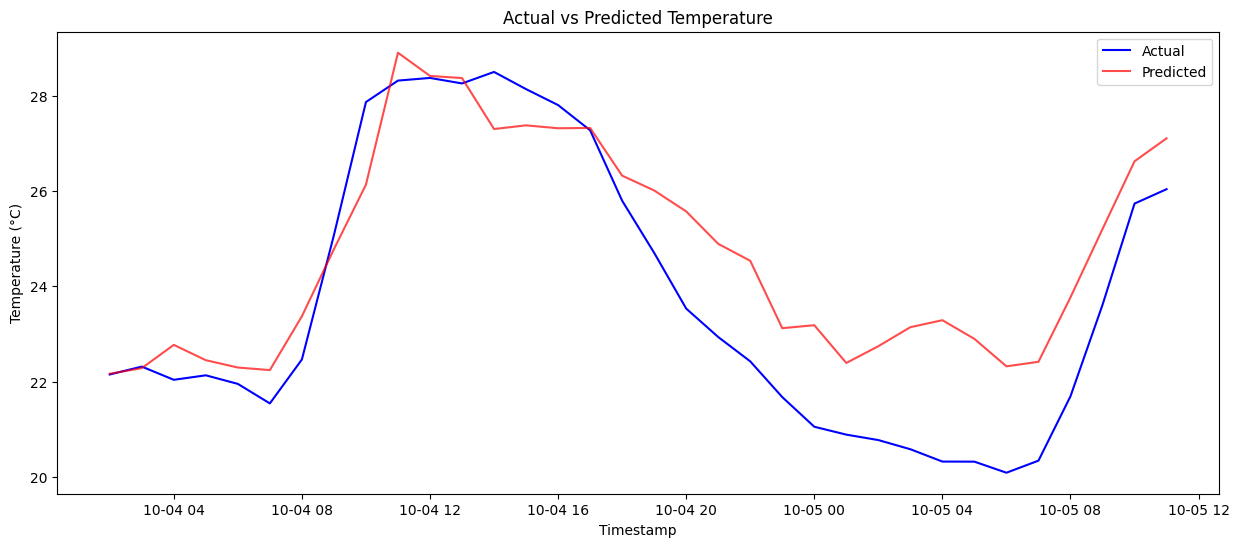

In [8]:
## Catboost regressor model and validation

cat_features = ['hour', 'day', 'month']
train_pool = Pool(X_train,y_train,cat_features = cat_features)
model = CatBoostRegressor(learning_rate = 0.4,iterations = 200,verbose=100)
model.fit(train_pool, eval_set = (X_valid, y_valid))

## Validation
y_pred = model.predict(X_valid)
mae = mean_absolute_error(y_valid, y_pred)
rmse = mean_squared_error(y_valid, y_pred, squared=False)

### Results
print(f"Validation MAE: {mae:.2f}")
print(f"Validation RMSE: {rmse:.2f}")

## Test Set
y_pred_test = model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

### Results
print(f"Test MAE: {mae_test:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")

plt.figure(figsize=(15, 6))
plt.plot(test['timestamp'], y_test, label='Actual', color='b')
plt.plot(test['timestamp'], y_pred_test, label='Predicted', color='r', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature')
plt.legend()

HGB Validation MAE: 0.28
HGB Validation RMSE: 0.35
HGB Test MAE: 0.63
HGB Test RMSE: 0.86


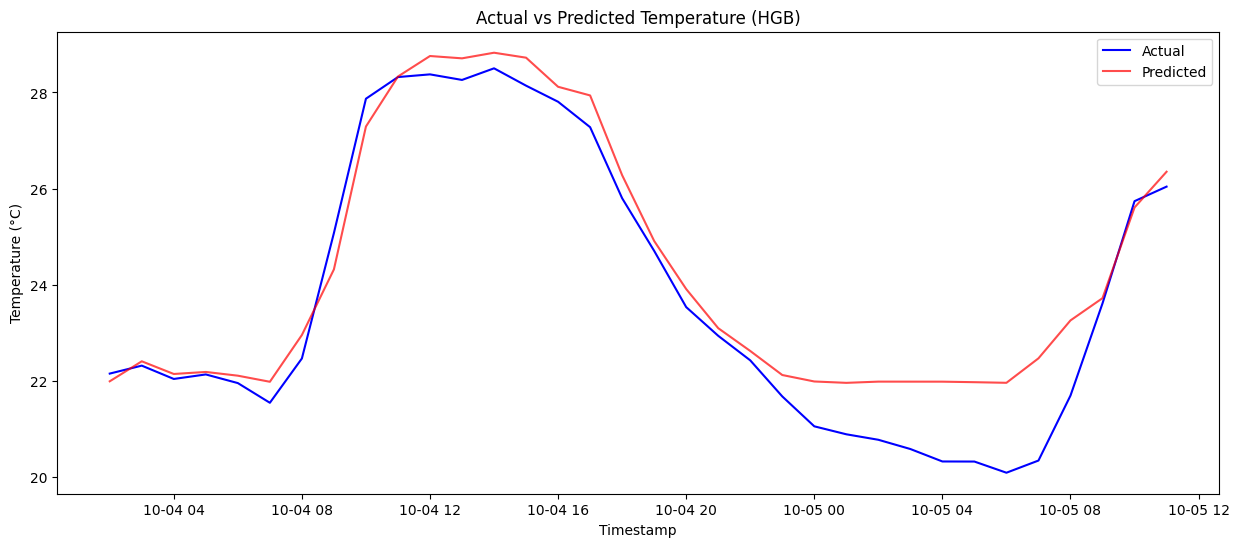

In [9]:
# Histogram gradient boosting regressor model and validation

hgb_model = HistGradientBoostingRegressor()
hgb_model.fit(X_train, y_train)

## Validation
hgb_y_pred = hgb_model.predict(X_valid)
hgb_mae = mean_absolute_error(y_valid, hgb_y_pred)
hgb_rmse = mean_squared_error(y_valid, hgb_y_pred, squared=False)

## Results
print(f"HGB Validation MAE: {hgb_mae:.2f}")
print(f"HGB Validation RMSE: {hgb_rmse:.2f}")

## Test set
y_pred_test = hgb_model.predict(X_test)
hgb_mae_test = mean_absolute_error(y_test, y_pred_test)
hgb_rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

## Results
print(f"HGB Test MAE: {hgb_mae_test:.2f}")
print(f"HGB Test RMSE: {hgb_rmse_test:.2f}")


## plot predictions vs actual
plt.figure(figsize=(15, 6))
plt.plot(test['timestamp'], y_test, label='Actual', color='b')
plt.plot(test['timestamp'], y_pred_test, label='Predicted', color='r', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature (HGB)')
plt.legend()
plt.show()

RF Validation MAE: 0.39
RF Validation RMSE: 0.49
RF Test MAE: 0.73
RF Test RMSE: 0.90


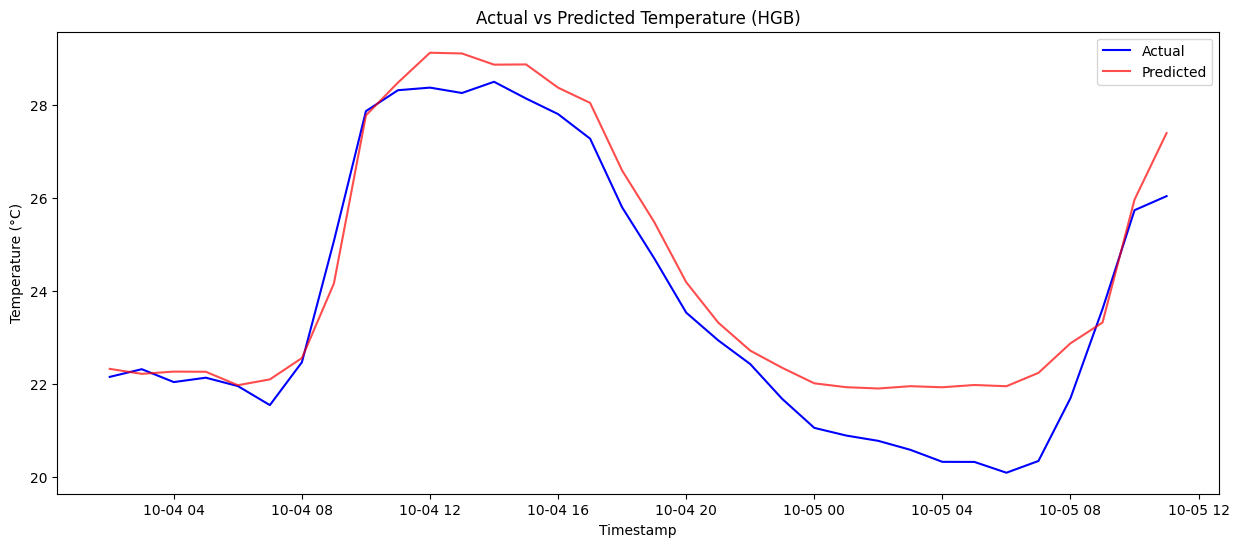

In [10]:
# Random Forest Regressor model and validation
## drop NA rows
X_train["temperature"] = y_train
X_train = X_train.dropna().reset_index(drop = True)
y_train = X_train["temperature"]
X_train = X_train.drop("temperature",axis = 1)

## Fit model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

## Validation
rf_y_pred = rf_model.predict(X_valid)
rf_mae = mean_absolute_error(y_valid, rf_y_pred)
rf_rmse = mean_squared_error(y_valid, rf_y_pred, squared=False)

## Results
print(f"RF Validation MAE: {rf_mae:.2f}")
print(f"RF Validation RMSE: {rf_rmse:.2f}")

## Test set
y_pred_test = rf_model.predict(X_test)
rf_mae_test = mean_absolute_error(y_test, y_pred_test)
rf_rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

## Results
print(f"RF Test MAE: {rf_mae_test:.2f}")
print(f"RF Test RMSE: {rf_rmse_test:.2f}")


## plot predictions vs actual
plt.figure(figsize=(15, 6))
plt.plot(test['timestamp'], y_test, label='Actual', color='b')
plt.plot(test['timestamp'], y_pred_test, label='Predicted', color='r', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature (HGB)')
plt.legend()
plt.show()

XGB Validation MAE: 0.38
XGB Validation RMSE: 0.50
XGB Test MAE: 0.71
XGB Test RMSE: 0.89


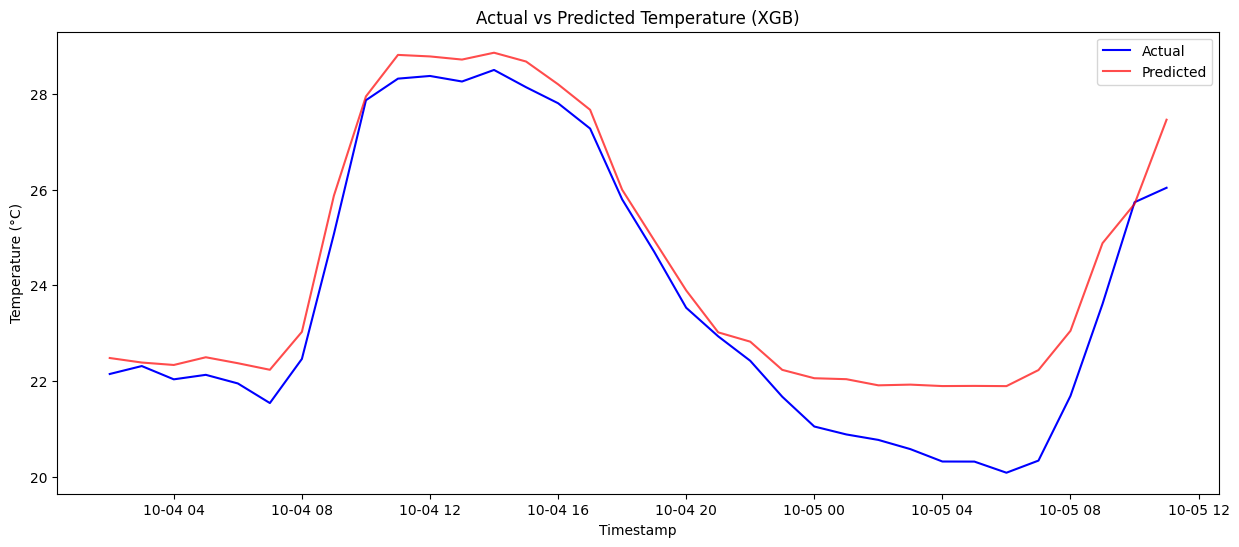

In [11]:
# XGBoostRegressor model and validation
## drop NA rows
X_train["temperature"] = y_train
X_train = X_train.dropna().reset_index(drop = True)
y_train = X_train["temperature"]
X_train = X_train.drop("temperature",axis = 1)

## Fit model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

## Validation
xgb_y_pred = xgb_model.predict(X_valid)
xgb_mae = mean_absolute_error(y_valid, xgb_y_pred)
xgb_rmse = mean_squared_error(y_valid, xgb_y_pred, squared=False)

## Results
print(f"XGB Validation MAE: {xgb_mae:.2f}")
print(f"XGB Validation RMSE: {xgb_rmse:.2f}")

## Test set
y_pred_test = xgb_model.predict(X_test)
xgb_mae_test = mean_absolute_error(y_test, y_pred_test)
xgb_rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

## Results
print(f"XGB Test MAE: {xgb_mae_test:.2f}")
print(f"XGB Test RMSE: {xgb_rmse_test:.2f}")


## plot predictions vs actual
plt.figure(figsize=(15, 6))
plt.plot(test['timestamp'], y_test, label='Actual', color='b')
plt.plot(test['timestamp'], y_pred_test, label='Predicted', color='r', alpha=0.7)
plt.xlabel('Timestamp')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs Predicted Temperature (XGB)')
plt.legend()
plt.show()

In [12]:

# =============================================================================
# OPTUNA İLE HİPERPARAMETRE OPTİMİZASYONU
# =============================================================================
class TimeSeriesHyperparameterOptimizer:
    """Zaman serisi modelleri için Optuna tabanlı hiperparametre optimizasyonu"""
    
    def __init__(self, X_train, y_train, n_splits=5, metric='mae'):
        self.X_train = X_train
        self.y_train = y_train
        self.n_splits = n_splits
        self.metric = metric
        self.tscv = TimeSeriesSplit(n_splits=n_splits)
        self.best_params = {}
        self.best_scores = {}
    
    # ==================================================
    # 🔹 Yardımcı fonksiyon: güvenli indexleme
    # ==================================================
    def _get_split_data(self, train_idx, val_idx):
        if isinstance(self.X_train, pd.DataFrame):
            X_tr, X_val = self.X_train.iloc[train_idx], self.X_train.iloc[val_idx]
            y_tr, y_val = self.y_train.iloc[train_idx], self.y_train.iloc[val_idx]
        else:  # numpy array ise
            X_tr, X_val = self.X_train[train_idx], self.X_train[val_idx]
            y_tr, y_val = self.y_train[train_idx], self.y_train[val_idx]
        return X_tr, X_val, y_tr, y_val
    
    # ==================================================
    # 🔹 Metriği hesapla
    # ==================================================
    def _calculate_metric(self, y_true, y_pred):
        if self.metric == 'mae':
            return mean_absolute_error(y_true, y_pred)
        elif self.metric == 'rmse':
            return np.sqrt(mean_squared_error(y_true, y_pred))
        elif self.metric == 'r2':
            return -r2_score(y_true, y_pred)  # Negatif çünkü minimize ediyoruz
    
    # ==================================================
    # 🔹 CatBoost
    # ==================================================
    def _objective_catboost(self, trial):
        params = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'depth': trial.suggest_int('depth', 4, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
            'random_strength': trial.suggest_float('random_strength', 0, 10),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'verbose': False,
            'random_state': 42
        }
        
        scores = []
        for train_idx, val_idx in self.tscv.split(self.X_train):
            X_tr, X_val, y_tr, y_val = self._get_split_data(train_idx, val_idx)
            
            model = CatBoostRegressor(**params)
            model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)
            
            y_pred = model.predict(X_val)
            score = self._calculate_metric(y_val, y_pred)
            scores.append(score)
            
            trial.report(score, len(scores))
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        
        return np.mean(scores)
    
    # ==================================================
    # 🔹 XGBoost
    # ==================================================
    def _objective_xgboost(self, trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
            'random_state': 42,
            'n_jobs': -1
        }
        
        scores = []
        for train_idx, val_idx in self.tscv.split(self.X_train):
            X_tr, X_val, y_tr, y_val = self._get_split_data(train_idx, val_idx)
            
            model = XGBRegressor(**params)
            model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], 
                      early_stopping_rounds=50, verbose=False)
            
            y_pred = model.predict(X_val)
            score = self._calculate_metric(y_val, y_pred)
            scores.append(score)
            
            trial.report(score, len(scores))
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        
        return np.mean(scores)
    
    # ==================================================
    # 🔹 Random Forest
    # ==================================================
    def _objective_random_forest(self, trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'random_state': 42,
            'n_jobs': -1
        }
        
        scores = []
        for train_idx, val_idx in self.tscv.split(self.X_train):
            X_tr, X_val, y_tr, y_val = self._get_split_data(train_idx, val_idx)
            
            model = RandomForestRegressor(**params)
            model.fit(X_tr, y_tr)
            
            y_pred = model.predict(X_val)
            score = self._calculate_metric(y_val, y_pred)
            scores.append(score)
        
        return np.mean(scores)
    
    # ==================================================
    # 🔹 HistGradientBoosting
    # ==================================================
    def _objective_histgb(self, trial):
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_iter': trial.suggest_int('max_iter', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 100),
            'l2_regularization': trial.suggest_float('l2_regularization', 0, 2),
            'max_bins': trial.suggest_int('max_bins', 128, 255),
            'early_stopping': True,
            'n_iter_no_change': 50,
            'validation_fraction': 0.1,
            'random_state': 42
        }
        
        scores = []
        for train_idx, val_idx in self.tscv.split(self.X_train):
            X_tr, X_val, y_tr, y_val = self._get_split_data(train_idx, val_idx)
            
            model = HistGradientBoostingRegressor(**params)
            model.fit(X_tr, y_tr)
            
            y_pred = model.predict(X_val)
            score = self._calculate_metric(y_val, y_pred)
            scores.append(score)
        
        return np.mean(scores)
    
    # ==================================================
    # 🔹 Optimizasyon
    # ==================================================
    def optimize(self, model_name, n_trials=100, timeout=None):
        print(f"\n{'='*60}")
        print(f"{model_name.upper()} için optimizasyon başlatılıyor...")
        print(f"{'='*60}\n")
        
        objective_map = {
            'catboost': self._objective_catboost,
            'xgboost': self._objective_xgboost,
            'random_forest': self._objective_random_forest,
            'histgb': self._objective_histgb
        }
        
        if model_name not in objective_map:
            raise ValueError(f"Geçersiz model adı: {model_name}")
        
        study = optuna.create_study(
            direction='minimize',
            sampler=TPESampler(seed=42),
            pruner=MedianPruner(n_startup_trials=10, n_warmup_steps=5)
        )
        
        study.optimize(
            objective_map[model_name],
            n_trials=n_trials,
            timeout=timeout,
            show_progress_bar=True
        )
        
        self.best_params[model_name] = study.best_params
        self.best_scores[model_name] = study.best_value
        
        print(f"\n✓ En iyi {self.metric.upper()}: {study.best_value:.4f}")
        print(f"✓ En iyi parametreler:")
        for param, value in study.best_params.items():
            print(f"  - {param}: {value}")
        
        return study.best_params
    
    def optimize_all(self, n_trials=100, timeout_per_model=None):
        models = ['catboost', 'xgboost', 'random_forest', 'histgb']
        for model_name in models:
            try:
                self.optimize(model_name, n_trials, timeout_per_model)
            except Exception as e:
                print(f"\n❌ {model_name} için hata: {str(e)}")
        return self.best_params
    
    def get_optimized_models(self):
        models = {}
        if 'catboost' in self.best_params:
            models['catboost'] = CatBoostRegressor(**self.best_params['catboost'], verbose=False)
        if 'xgboost' in self.best_params:
            models['xgboost'] = XGBRegressor(**self.best_params['xgboost'])
        if 'random_forest' in self.best_params:
            models['random_forest'] = RandomForestRegressor(**self.best_params['random_forest'])
        if 'histgb' in self.best_params:
            models['histgb'] = HistGradientBoostingRegressor(**self.best_params['histgb'])
        return models


if __name__ == "__main__":
    
    X, y = X_train,y_train
    
    # Optuna
    print("OPTUNA ile Optimizasyon")
    print("="*60)
    
    optimizer = TimeSeriesHyperparameterOptimizer(
        X_train=X,
        y_train=y,
        n_splits=5,
        metric='mae'
    )
    
    # Tek model için
    best_params_catboost = optimizer.optimize('catboost', n_trials=50)
    
    # Veya tüm modeller için
    all_best_params = optimizer.optimize_all(n_trials=50)
    
    # Optimize edilmiş modelleri al
    optimized_models = optimizer.get_optimized_models()
    
    print("\n" + "="*60)
    print("ENSEMBLE MODEL - Optimize Edilmiş Modellerin Ortalaması")
    print("="*60)
    
    # Ensemble tahmin
    predictions = []
    for name, model in optimized_models.items():
        model.fit(X, y)
        pred = model.predict(X_test)
        predictions.append(pred)
    
    ensemble_prediction = np.mean(predictions, axis=0)

[I 2025-10-05 11:07:09,324] A new study created in memory with name: no-name-2cc7e52b-92ef-49c5-957f-3575f08e8d41


OPTUNA ile Optimizasyon

CATBOOST için optimizasyon başlatılıyor...



Best trial: 0. Best value: 1.32963:   2%|▏         | 1/50 [01:42<1:23:25, 102.16s/it]

[I 2025-10-05 11:08:51,509] Trial 0 finished with value: 1.3296301057506523 and parameters: {'iterations': 437, 'learning_rate': 0.2536999076681772, 'depth': 9, 'l2_leaf_reg': 6.387926357773329, 'min_data_in_leaf': 8, 'random_strength': 1.5599452033620265, 'bagging_temperature': 0.05808361216819946, 'border_count': 226}. Best is trial 0 with value: 1.3296301057506523.


Best trial: 1. Best value: 0.956624:   4%|▍         | 2/50 [01:46<35:53, 44.87s/it]   

[I 2025-10-05 11:08:56,280] Trial 1 finished with value: 0.9566240279406827 and parameters: {'iterations': 641, 'learning_rate': 0.11114989443094977, 'depth': 4, 'l2_leaf_reg': 9.72918866945795, 'min_data_in_leaf': 42, 'random_strength': 2.1233911067827616, 'bagging_temperature': 0.18182496720710062, 'border_count': 73}. Best is trial 1 with value: 0.9566240279406827.


Best trial: 1. Best value: 0.956624:   6%|▌         | 3/50 [02:09<27:11, 34.71s/it]

[I 2025-10-05 11:09:18,891] Trial 2 finished with value: 1.1923313844006538 and parameters: {'iterations': 374, 'learning_rate': 0.05958389350068958, 'depth': 7, 'l2_leaf_reg': 3.6210622617823773, 'min_data_in_leaf': 31, 'random_strength': 1.3949386065204183, 'bagging_temperature': 0.29214464853521815, 'border_count': 114}. Best is trial 1 with value: 0.9566240279406827.


Best trial: 3. Best value: 0.927237:   8%|▊         | 4/50 [02:15<18:00, 23.48s/it]

[I 2025-10-05 11:09:25,168] Trial 3 finished with value: 0.9272370222577567 and parameters: {'iterations': 510, 'learning_rate': 0.14447746112718687, 'depth': 5, 'l2_leaf_reg': 5.628109945722504, 'min_data_in_leaf': 30, 'random_strength': 0.46450412719997725, 'bagging_temperature': 0.6075448519014384, 'border_count': 70}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  10%|█         | 5/50 [03:11<26:12, 34.95s/it]

[I 2025-10-05 11:10:20,454] Trial 4 finished with value: 1.4207266598895294 and parameters: {'iterations': 158, 'learning_rate': 0.2521267904777921, 'depth': 10, 'l2_leaf_reg': 8.275576133048151, 'min_data_in_leaf': 16, 'random_strength': 0.9767211400638387, 'bagging_temperature': 0.6842330265121569, 'border_count': 130}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  12%|█▏        | 6/50 [03:14<17:49, 24.30s/it]

[I 2025-10-05 11:10:24,084] Trial 5 finished with value: 1.1103315934010933 and parameters: {'iterations': 209, 'learning_rate': 0.05388108577817234, 'depth': 4, 'l2_leaf_reg': 9.18388361870904, 'min_data_in_leaf': 13, 'random_strength': 6.62522284353982, 'bagging_temperature': 0.31171107608941095, 'border_count': 148}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  14%|█▍        | 7/50 [09:15<1:36:08, 134.14s/it]

[I 2025-10-05 11:16:24,377] Trial 6 finished with value: 1.5797593326450214 and parameters: {'iterations': 592, 'learning_rate': 0.01875220945578641, 'depth': 10, 'l2_leaf_reg': 7.976195410250031, 'min_data_in_leaf': 47, 'random_strength': 8.948273504276488, 'bagging_temperature': 0.5978999788110851, 'border_count': 238}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  16%|█▌        | 8/50 [09:17<1:04:34, 92.26s/it] 

[I 2025-10-05 11:16:26,947] Trial 7 finished with value: 1.2843772120065986 and parameters: {'iterations': 179, 'learning_rate': 0.01947558230629543, 'depth': 4, 'l2_leaf_reg': 3.927972976869379, 'min_data_in_leaf': 20, 'random_strength': 2.713490317738959, 'bagging_temperature': 0.8287375091519293, 'border_count': 111}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  18%|█▊        | 9/50 [09:22<44:23, 64.97s/it]  

[I 2025-10-05 11:16:31,910] Trial 8 finished with value: 0.9883891889139518 and parameters: {'iterations': 353, 'learning_rate': 0.06333268775321843, 'depth': 4, 'l2_leaf_reg': 8.219772826786357, 'min_data_in_leaf': 4, 'random_strength': 9.868869366005173, 'bagging_temperature': 0.7722447692966574, 'border_count': 76}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  20%|██        | 10/50 [09:29<31:18, 46.97s/it]

[I 2025-10-05 11:16:38,558] Trial 9 finished with value: 1.3234631733835927 and parameters: {'iterations': 104, 'learning_rate': 0.1601531217136121, 'depth': 8, 'l2_leaf_reg': 7.561064512368886, 'min_data_in_leaf': 39, 'random_strength': 0.7404465173409036, 'bagging_temperature': 0.3584657285442726, 'border_count': 57}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  22%|██▏       | 11/50 [09:40<23:30, 36.16s/it]

[I 2025-10-05 11:16:50,218] Trial 10 finished with value: 1.1848476422671983 and parameters: {'iterations': 930, 'learning_rate': 0.010206070557576998, 'depth': 6, 'l2_leaf_reg': 1.1616568805333776, 'min_data_in_leaf': 29, 'random_strength': 4.268128953833139, 'bagging_temperature': 0.9597707459454202, 'border_count': 34}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  24%|██▍       | 12/50 [10:01<19:48, 31.29s/it]

[I 2025-10-05 11:17:10,357] Trial 11 finished with value: 1.25216781232804 and parameters: {'iterations': 688, 'learning_rate': 0.11438892897450689, 'depth': 6, 'l2_leaf_reg': 5.015306343773882, 'min_data_in_leaf': 40, 'random_strength': 3.587862975096967, 'bagging_temperature': 0.06782026776262084, 'border_count': 174}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  26%|██▌       | 13/50 [10:06<14:26, 23.42s/it]

[I 2025-10-05 11:17:15,676] Trial 12 finished with value: 0.947645969224747 and parameters: {'iterations': 740, 'learning_rate': 0.10781135193503111, 'depth': 5, 'l2_leaf_reg': 1.611791265993583, 'min_data_in_leaf': 49, 'random_strength': 0.07757683332151444, 'bagging_temperature': 0.4687052188878424, 'border_count': 85}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  28%|██▊       | 14/50 [10:19<12:07, 20.21s/it]

[I 2025-10-05 11:17:28,486] Trial 13 finished with value: 1.0130301742044046 and parameters: {'iterations': 827, 'learning_rate': 0.09719442732457283, 'depth': 6, 'l2_leaf_reg': 1.1649560268417756, 'min_data_in_leaf': 50, 'random_strength': 0.029518948879441897, 'bagging_temperature': 0.5296370870614441, 'border_count': 94}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  30%|███       | 15/50 [10:23<09:05, 15.58s/it]

[I 2025-10-05 11:17:33,336] Trial 14 finished with value: 1.205187716130724 and parameters: {'iterations': 789, 'learning_rate': 0.1627363004643333, 'depth': 5, 'l2_leaf_reg': 3.015763533142166, 'min_data_in_leaf': 34, 'random_strength': 5.454273262562598, 'bagging_temperature': 0.45784040668338816, 'border_count': 32}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  32%|███▏      | 16/50 [10:30<07:15, 12.82s/it]

[I 2025-10-05 11:17:39,734] Trial 15 finished with value: 1.1625247347975793 and parameters: {'iterations': 487, 'learning_rate': 0.03666491440817301, 'depth': 5, 'l2_leaf_reg': 5.736330003702177, 'min_data_in_leaf': 23, 'random_strength': 6.646179710147847, 'bagging_temperature': 0.4857917809520678, 'border_count': 64}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  34%|███▍      | 17/50 [10:55<09:05, 16.53s/it]

[I 2025-10-05 11:18:04,902] Trial 16 finished with value: 1.3301734583034812 and parameters: {'iterations': 794, 'learning_rate': 0.16228643858095243, 'depth': 7, 'l2_leaf_reg': 2.4799176592871075, 'min_data_in_leaf': 34, 'random_strength': 2.953250849262419, 'bagging_temperature': 0.6700029383194562, 'border_count': 175}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  36%|███▌      | 18/50 [11:05<07:43, 14.47s/it]

[I 2025-10-05 11:18:14,567] Trial 17 finished with value: 0.9580151891727443 and parameters: {'iterations': 977, 'learning_rate': 0.08407654179943178, 'depth': 5, 'l2_leaf_reg': 4.378871425983883, 'min_data_in_leaf': 45, 'random_strength': 0.27219026391196977, 'bagging_temperature': 0.4155713133449492, 'border_count': 93}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  38%|███▊      | 19/50 [12:41<20:08, 38.98s/it]

[I 2025-10-05 11:19:50,648] Trial 18 finished with value: 1.2705555014832997 and parameters: {'iterations': 531, 'learning_rate': 0.0354903209946135, 'depth': 8, 'l2_leaf_reg': 6.638310221964548, 'min_data_in_leaf': 27, 'random_strength': 5.067762568716672, 'bagging_temperature': 0.9977925149306185, 'border_count': 164}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  40%|████      | 20/50 [12:50<15:04, 30.14s/it]

[I 2025-10-05 11:20:00,182] Trial 19 finished with value: 1.0936578484024435 and parameters: {'iterations': 297, 'learning_rate': 0.17562882307394703, 'depth': 5, 'l2_leaf_reg': 2.2753917559527057, 'min_data_in_leaf': 21, 'random_strength': 1.7046127853211313, 'bagging_temperature': 0.5704422182963745, 'border_count': 214}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  42%|████▏     | 21/50 [12:59<11:27, 23.69s/it]

[I 2025-10-05 11:20:08,842] Trial 20 finished with value: 1.2596674345653471 and parameters: {'iterations': 707, 'learning_rate': 0.28922136247620234, 'depth': 7, 'l2_leaf_reg': 5.153942024719667, 'min_data_in_leaf': 34, 'random_strength': 3.681644226027468, 'bagging_temperature': 0.8399369774182369, 'border_count': 49}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  44%|████▍     | 22/50 [13:05<08:38, 18.53s/it]

[I 2025-10-05 11:20:15,335] Trial 21 finished with value: 0.9679005015515194 and parameters: {'iterations': 639, 'learning_rate': 0.1187169111090128, 'depth': 4, 'l2_leaf_reg': 9.944916782654131, 'min_data_in_leaf': 42, 'random_strength': 2.2671795225487026, 'bagging_temperature': 0.21911351529495246, 'border_count': 83}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  46%|████▌     | 23/50 [13:16<07:15, 16.13s/it]

[I 2025-10-05 11:20:25,849] Trial 22 finished with value: 0.961418492489084 and parameters: {'iterations': 584, 'learning_rate': 0.0786498376330784, 'depth': 5, 'l2_leaf_reg': 6.668688078778235, 'min_data_in_leaf': 48, 'random_strength': 0.07693932332199449, 'bagging_temperature': 0.1922382635295366, 'border_count': 111}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  48%|████▊     | 24/50 [13:32<06:55, 15.98s/it]

[I 2025-10-05 11:20:41,475] Trial 23 finished with value: 1.1561747141055174 and parameters: {'iterations': 711, 'learning_rate': 0.1248804011163616, 'depth': 6, 'l2_leaf_reg': 9.919469907565304, 'min_data_in_leaf': 44, 'random_strength': 2.01746873047762, 'bagging_temperature': 0.15869393615745006, 'border_count': 71}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  50%|█████     | 25/50 [13:36<05:15, 12.64s/it]

[I 2025-10-05 11:20:46,318] Trial 24 finished with value: 1.066798209062545 and parameters: {'iterations': 854, 'learning_rate': 0.18964660272040637, 'depth': 4, 'l2_leaf_reg': 7.209349494761405, 'min_data_in_leaf': 38, 'random_strength': 0.8641910833439502, 'bagging_temperature': 0.6405301333656301, 'border_count': 51}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  52%|█████▏    | 26/50 [13:48<04:54, 12.29s/it]

[I 2025-10-05 11:20:57,788] Trial 25 finished with value: 1.0342851456069921 and parameters: {'iterations': 634, 'learning_rate': 0.04038370046194382, 'depth': 5, 'l2_leaf_reg': 1.9781506763879513, 'min_data_in_leaf': 38, 'random_strength': 2.543351585784312, 'bagging_temperature': 0.3819996117906489, 'border_count': 95}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  54%|█████▍    | 27/50 [13:56<04:13, 11.04s/it]

[I 2025-10-05 11:21:05,918] Trial 26 finished with value: 0.948536965686456 and parameters: {'iterations': 486, 'learning_rate': 0.08276621890967116, 'depth': 4, 'l2_leaf_reg': 9.203877859871302, 'min_data_in_leaf': 50, 'random_strength': 0.9358829513406056, 'bagging_temperature': 0.7698815649804504, 'border_count': 137}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  56%|█████▌    | 28/50 [14:22<05:38, 15.40s/it]

[I 2025-10-05 11:21:31,508] Trial 27 finished with value: 1.0910345534227477 and parameters: {'iterations': 462, 'learning_rate': 0.07371116483655127, 'depth': 6, 'l2_leaf_reg': 8.803133780208196, 'min_data_in_leaf': 50, 'random_strength': 0.9366982098756091, 'bagging_temperature': 0.7328676375549946, 'border_count': 193}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  58%|█████▊    | 29/50 [14:32<04:54, 14.03s/it]

[I 2025-10-05 11:21:42,344] Trial 28 finished with value: 1.1996213163276388 and parameters: {'iterations': 414, 'learning_rate': 0.05048150804764244, 'depth': 5, 'l2_leaf_reg': 4.3779524816164574, 'min_data_in_leaf': 46, 'random_strength': 7.625658160608292, 'bagging_temperature': 0.9060160485593964, 'border_count': 143}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  60%|██████    | 30/50 [15:16<07:35, 22.79s/it]

[I 2025-10-05 11:22:25,574] Trial 29 finished with value: 1.276272958314587 and parameters: {'iterations': 520, 'learning_rate': 0.21280897879337077, 'depth': 8, 'l2_leaf_reg': 5.660520217661527, 'min_data_in_leaf': 6, 'random_strength': 1.5164821418599956, 'bagging_temperature': 0.7444004229539366, 'border_count': 126}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  62%|██████▏   | 31/50 [15:20<05:26, 17.20s/it]

[I 2025-10-05 11:22:29,719] Trial 30 finished with value: 0.994176436949342 and parameters: {'iterations': 265, 'learning_rate': 0.1287361581539311, 'depth': 4, 'l2_leaf_reg': 6.1105957350265285, 'min_data_in_leaf': 1, 'random_strength': 0.677019233298843, 'bagging_temperature': 0.5334098296726653, 'border_count': 139}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  64%|██████▍   | 32/50 [15:26<04:12, 14.02s/it]

[I 2025-10-05 11:22:36,331] Trial 31 finished with value: 0.9302091207967236 and parameters: {'iterations': 744, 'learning_rate': 0.10023283082851697, 'depth': 4, 'l2_leaf_reg': 9.100281287831415, 'min_data_in_leaf': 42, 'random_strength': 1.5061966685954375, 'bagging_temperature': 0.6118149061874859, 'border_count': 84}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  66%|██████▌   | 33/50 [15:35<03:30, 12.38s/it]

[I 2025-10-05 11:22:44,873] Trial 32 finished with value: 0.9594707070123629 and parameters: {'iterations': 742, 'learning_rate': 0.09494051229962215, 'depth': 4, 'l2_leaf_reg': 9.13708732504452, 'min_data_in_leaf': 42, 'random_strength': 1.6405885188562914, 'bagging_temperature': 0.6152233530549658, 'border_count': 84}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  68%|██████▊   | 34/50 [15:47<03:14, 12.14s/it]

[I 2025-10-05 11:22:56,460] Trial 33 finished with value: 1.048026223421685 and parameters: {'iterations': 869, 'learning_rate': 0.1389464765965611, 'depth': 5, 'l2_leaf_reg': 8.78089630784424, 'min_data_in_leaf': 50, 'random_strength': 1.262676366499572, 'bagging_temperature': 0.8253772053491368, 'border_count': 105}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  70%|███████   | 35/50 [15:53<02:36, 10.43s/it]

[I 2025-10-05 11:23:02,889] Trial 34 finished with value: 0.9596849418777411 and parameters: {'iterations': 423, 'learning_rate': 0.06786319961505152, 'depth': 4, 'l2_leaf_reg': 3.2178717954692675, 'min_data_in_leaf': 43, 'random_strength': 0.46669536609189066, 'bagging_temperature': 0.6913956387976952, 'border_count': 126}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  72%|███████▏  | 36/50 [15:58<02:04,  8.92s/it]

[I 2025-10-05 11:23:08,292] Trial 35 finished with value: 0.9939156979544835 and parameters: {'iterations': 577, 'learning_rate': 0.09658363949688054, 'depth': 4, 'l2_leaf_reg': 7.440695634024838, 'min_data_in_leaf': 11, 'random_strength': 3.1373060579473337, 'bagging_temperature': 0.578144537830852, 'border_count': 43}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  74%|███████▍  | 37/50 [16:04<01:41,  7.81s/it]

[I 2025-10-05 11:23:13,511] Trial 36 finished with value: 0.9713465070589254 and parameters: {'iterations': 341, 'learning_rate': 0.22519435032363658, 'depth': 5, 'l2_leaf_reg': 8.556712777444476, 'min_data_in_leaf': 31, 'random_strength': 0.025507501816106136, 'bagging_temperature': 0.45985219913433795, 'border_count': 68}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  76%|███████▌  | 38/50 [16:13<01:40,  8.36s/it]

[I 2025-10-05 11:23:23,151] Trial 37 finished with value: 0.9891811692638752 and parameters: {'iterations': 489, 'learning_rate': 0.0968687075429894, 'depth': 4, 'l2_leaf_reg': 9.546207788967699, 'min_data_in_leaf': 47, 'random_strength': 1.978729940844684, 'bagging_temperature': 0.7040548399760244, 'border_count': 155}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  78%|███████▊  | 39/50 [16:38<02:24, 13.13s/it]

[I 2025-10-05 11:23:47,425] Trial 38 finished with value: 1.0727134438781243 and parameters: {'iterations': 651, 'learning_rate': 0.04666877399137917, 'depth': 6, 'l2_leaf_reg': 7.7782013689427165, 'min_data_in_leaf': 37, 'random_strength': 1.0724924909359244, 'bagging_temperature': 0.28118906487538914, 'border_count': 122}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  80%|████████  | 40/50 [21:04<14:51, 89.16s/it]

[I 2025-10-05 11:28:13,989] Trial 39 finished with value: 1.3716663152330089 and parameters: {'iterations': 755, 'learning_rate': 0.02543871097472224, 'depth': 9, 'l2_leaf_reg': 7.069809779068425, 'min_data_in_leaf': 17, 'random_strength': 1.4005370125458585, 'bagging_temperature': 0.6399456681778237, 'border_count': 197}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  82%|████████▏ | 41/50 [21:09<09:34, 63.87s/it]

[I 2025-10-05 11:28:18,852] Trial 40 finished with value: 1.0686260826150675 and parameters: {'iterations': 388, 'learning_rate': 0.05739661792198385, 'depth': 4, 'l2_leaf_reg': 9.300180114087812, 'min_data_in_leaf': 41, 'random_strength': 4.117939075030285, 'bagging_temperature': 0.7895610875403218, 'border_count': 104}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  84%|████████▍ | 42/50 [21:15<06:12, 46.51s/it]

[I 2025-10-05 11:28:24,854] Trial 41 finished with value: 0.9641348252503599 and parameters: {'iterations': 615, 'learning_rate': 0.10528069172985206, 'depth': 4, 'l2_leaf_reg': 8.245836260329298, 'min_data_in_leaf': 47, 'random_strength': 2.464357469541427, 'bagging_temperature': 0.045244167612686126, 'border_count': 80}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  86%|████████▌ | 43/50 [21:24<04:07, 35.33s/it]

[I 2025-10-05 11:28:34,102] Trial 42 finished with value: 0.9647571064518796 and parameters: {'iterations': 663, 'learning_rate': 0.08082357329464972, 'depth': 5, 'l2_leaf_reg': 9.257086600292254, 'min_data_in_leaf': 45, 'random_strength': 0.8335846066354742, 'bagging_temperature': 0.09229101278253965, 'border_count': 57}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  88%|████████▊ | 44/50 [21:29<02:37, 26.29s/it]

[I 2025-10-05 11:28:39,278] Trial 43 finished with value: 0.9688641564512338 and parameters: {'iterations': 586, 'learning_rate': 0.15063520940603312, 'depth': 4, 'l2_leaf_reg': 9.689710345625372, 'min_data_in_leaf': 35, 'random_strength': 0.5357123721335867, 'bagging_temperature': 0.3265464442969167, 'border_count': 91}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  90%|█████████ | 45/50 [21:45<01:55, 23.10s/it]

[I 2025-10-05 11:28:54,930] Trial 44 finished with value: 0.9556381842683462 and parameters: {'iterations': 896, 'learning_rate': 0.062416646408435646, 'depth': 4, 'l2_leaf_reg': 7.984034050358118, 'min_data_in_leaf': 27, 'random_strength': 1.9519886251796201, 'bagging_temperature': 0.8932078456752284, 'border_count': 246}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  92%|█████████▏| 46/50 [22:12<01:36, 24.22s/it]

[I 2025-10-05 11:29:21,782] Trial 45 finished with value: 1.0331573062262418 and parameters: {'iterations': 902, 'learning_rate': 0.061339829274154246, 'depth': 5, 'l2_leaf_reg': 8.660183476692191, 'min_data_in_leaf': 25, 'random_strength': 1.8596640154578843, 'bagging_temperature': 0.927028804937089, 'border_count': 251}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  94%|█████████▍| 47/50 [22:25<01:03, 21.01s/it]

[I 2025-10-05 11:29:35,304] Trial 46 finished with value: 0.9483791310566536 and parameters: {'iterations': 962, 'learning_rate': 0.07093862045017345, 'depth': 4, 'l2_leaf_reg': 7.812253077738389, 'min_data_in_leaf': 29, 'random_strength': 1.2433545869108986, 'bagging_temperature': 0.8876867965136821, 'border_count': 224}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  96%|█████████▌| 48/50 [23:09<00:55, 27.67s/it]

[I 2025-10-05 11:30:18,506] Trial 47 finished with value: 1.121076196420321 and parameters: {'iterations': 996, 'learning_rate': 0.0856471892183615, 'depth': 6, 'l2_leaf_reg': 4.54220719756891, 'min_data_in_leaf': 29, 'random_strength': 1.309948445653056, 'bagging_temperature': 0.5227449761537956, 'border_count': 226}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 48. Best value: 0.884621:  98%|█████████▊| 49/50 [23:16<00:21, 21.46s/it]

[I 2025-10-05 11:30:25,470] Trial 48 finished with value: 0.8846209245992063 and parameters: {'iterations': 963, 'learning_rate': 0.13955558743816626, 'depth': 4, 'l2_leaf_reg': 3.8550441451519015, 'min_data_in_leaf': 32, 'random_strength': 0.46246304650310066, 'bagging_temperature': 0.7944023148251358, 'border_count': 189}. Best is trial 48 with value: 0.8846209245992063.


Best trial: 48. Best value: 0.884621: 100%|██████████| 50/50 [23:27<00:00, 28.16s/it]
[I 2025-10-05 11:30:37,262] A new study created in memory with name: no-name-6d39704d-adf9-4f07-aefd-4325cb996e03


[I 2025-10-05 11:30:37,254] Trial 49 finished with value: 0.9966626038386514 and parameters: {'iterations': 953, 'learning_rate': 0.11691494654164893, 'depth': 5, 'l2_leaf_reg': 1.471082479733084, 'min_data_in_leaf': 31, 'random_strength': 0.4495050225211825, 'bagging_temperature': 0.8631314661113474, 'border_count': 208}. Best is trial 48 with value: 0.8846209245992063.

✓ En iyi MAE: 0.8846
✓ En iyi parametreler:
  - iterations: 963
  - learning_rate: 0.13955558743816626
  - depth: 4
  - l2_leaf_reg: 3.8550441451519015
  - min_data_in_leaf: 32
  - random_strength: 0.46246304650310066
  - bagging_temperature: 0.7944023148251358
  - border_count: 189

CATBOOST için optimizasyon başlatılıyor...



Best trial: 0. Best value: 1.32963:   2%|▏         | 1/50 [01:45<1:26:30, 105.94s/it]

[I 2025-10-05 11:32:23,195] Trial 0 finished with value: 1.3296301057506523 and parameters: {'iterations': 437, 'learning_rate': 0.2536999076681772, 'depth': 9, 'l2_leaf_reg': 6.387926357773329, 'min_data_in_leaf': 8, 'random_strength': 1.5599452033620265, 'bagging_temperature': 0.05808361216819946, 'border_count': 226}. Best is trial 0 with value: 1.3296301057506523.


Best trial: 1. Best value: 0.956624:   4%|▍         | 2/50 [01:52<37:57, 47.45s/it]   

[I 2025-10-05 11:32:29,704] Trial 1 finished with value: 0.9566240279406827 and parameters: {'iterations': 641, 'learning_rate': 0.11114989443094977, 'depth': 4, 'l2_leaf_reg': 9.72918866945795, 'min_data_in_leaf': 42, 'random_strength': 2.1233911067827616, 'bagging_temperature': 0.18182496720710062, 'border_count': 73}. Best is trial 1 with value: 0.9566240279406827.


Best trial: 1. Best value: 0.956624:   6%|▌         | 3/50 [02:14<28:14, 36.06s/it]

[I 2025-10-05 11:32:52,207] Trial 2 finished with value: 1.1923313844006538 and parameters: {'iterations': 374, 'learning_rate': 0.05958389350068958, 'depth': 7, 'l2_leaf_reg': 3.6210622617823773, 'min_data_in_leaf': 31, 'random_strength': 1.3949386065204183, 'bagging_temperature': 0.29214464853521815, 'border_count': 114}. Best is trial 1 with value: 0.9566240279406827.


Best trial: 3. Best value: 0.927237:   8%|▊         | 4/50 [02:20<18:31, 24.16s/it]

[I 2025-10-05 11:32:58,124] Trial 3 finished with value: 0.9272370222577567 and parameters: {'iterations': 510, 'learning_rate': 0.14447746112718687, 'depth': 5, 'l2_leaf_reg': 5.628109945722504, 'min_data_in_leaf': 30, 'random_strength': 0.46450412719997725, 'bagging_temperature': 0.6075448519014384, 'border_count': 70}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  10%|█         | 5/50 [03:37<32:24, 43.20s/it]

[I 2025-10-05 11:34:15,090] Trial 4 finished with value: 1.4207266598895294 and parameters: {'iterations': 158, 'learning_rate': 0.2521267904777921, 'depth': 10, 'l2_leaf_reg': 8.275576133048151, 'min_data_in_leaf': 16, 'random_strength': 0.9767211400638387, 'bagging_temperature': 0.6842330265121569, 'border_count': 130}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  12%|█▏        | 6/50 [03:41<21:49, 29.75s/it]

[I 2025-10-05 11:34:18,740] Trial 5 finished with value: 1.1103315934010933 and parameters: {'iterations': 209, 'learning_rate': 0.05388108577817234, 'depth': 4, 'l2_leaf_reg': 9.18388361870904, 'min_data_in_leaf': 13, 'random_strength': 6.62522284353982, 'bagging_temperature': 0.31171107608941095, 'border_count': 148}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  14%|█▍        | 7/50 [10:19<1:47:34, 150.10s/it]

[I 2025-10-05 11:40:56,599] Trial 6 finished with value: 1.5797593326450214 and parameters: {'iterations': 592, 'learning_rate': 0.01875220945578641, 'depth': 10, 'l2_leaf_reg': 7.976195410250031, 'min_data_in_leaf': 47, 'random_strength': 8.948273504276488, 'bagging_temperature': 0.5978999788110851, 'border_count': 238}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  16%|█▌        | 8/50 [10:21<1:12:11, 103.14s/it]

[I 2025-10-05 11:40:59,197] Trial 7 finished with value: 1.2843772120065986 and parameters: {'iterations': 179, 'learning_rate': 0.01947558230629543, 'depth': 4, 'l2_leaf_reg': 3.927972976869379, 'min_data_in_leaf': 20, 'random_strength': 2.713490317738959, 'bagging_temperature': 0.8287375091519293, 'border_count': 111}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  18%|█▊        | 9/50 [10:25<49:18, 72.15s/it]   

[I 2025-10-05 11:41:03,205] Trial 8 finished with value: 0.9883891889139518 and parameters: {'iterations': 353, 'learning_rate': 0.06333268775321843, 'depth': 4, 'l2_leaf_reg': 8.219772826786357, 'min_data_in_leaf': 4, 'random_strength': 9.868869366005173, 'bagging_temperature': 0.7722447692966574, 'border_count': 76}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  20%|██        | 10/50 [10:32<34:38, 51.96s/it]

[I 2025-10-05 11:41:09,967] Trial 9 finished with value: 1.3234631733835927 and parameters: {'iterations': 104, 'learning_rate': 0.1601531217136121, 'depth': 8, 'l2_leaf_reg': 7.561064512368886, 'min_data_in_leaf': 39, 'random_strength': 0.7404465173409036, 'bagging_temperature': 0.3584657285442726, 'border_count': 57}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  22%|██▏       | 11/50 [10:44<25:50, 39.76s/it]

[I 2025-10-05 11:41:22,060] Trial 10 finished with value: 1.1848476422671983 and parameters: {'iterations': 930, 'learning_rate': 0.010206070557576998, 'depth': 6, 'l2_leaf_reg': 1.1616568805333776, 'min_data_in_leaf': 29, 'random_strength': 4.268128953833139, 'bagging_temperature': 0.9597707459454202, 'border_count': 34}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  24%|██▍       | 12/50 [11:05<21:29, 33.94s/it]

[I 2025-10-05 11:41:42,673] Trial 11 finished with value: 1.25216781232804 and parameters: {'iterations': 688, 'learning_rate': 0.11438892897450689, 'depth': 6, 'l2_leaf_reg': 5.015306343773882, 'min_data_in_leaf': 40, 'random_strength': 3.587862975096967, 'bagging_temperature': 0.06782026776262084, 'border_count': 174}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  26%|██▌       | 13/50 [11:10<15:36, 25.30s/it]

[I 2025-10-05 11:41:48,117] Trial 12 finished with value: 0.947645969224747 and parameters: {'iterations': 740, 'learning_rate': 0.10781135193503111, 'depth': 5, 'l2_leaf_reg': 1.611791265993583, 'min_data_in_leaf': 49, 'random_strength': 0.07757683332151444, 'bagging_temperature': 0.4687052188878424, 'border_count': 85}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  28%|██▊       | 14/50 [11:25<13:17, 22.16s/it]

[I 2025-10-05 11:42:03,012] Trial 13 finished with value: 1.0130301742044046 and parameters: {'iterations': 827, 'learning_rate': 0.09719442732457283, 'depth': 6, 'l2_leaf_reg': 1.1649560268417756, 'min_data_in_leaf': 50, 'random_strength': 0.029518948879441897, 'bagging_temperature': 0.5296370870614441, 'border_count': 94}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  30%|███       | 15/50 [11:30<09:54, 16.99s/it]

[I 2025-10-05 11:42:08,020] Trial 14 finished with value: 1.205187716130724 and parameters: {'iterations': 789, 'learning_rate': 0.1627363004643333, 'depth': 5, 'l2_leaf_reg': 3.015763533142166, 'min_data_in_leaf': 34, 'random_strength': 5.454273262562598, 'bagging_temperature': 0.45784040668338816, 'border_count': 32}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  32%|███▏      | 16/50 [11:37<07:53, 13.94s/it]

[I 2025-10-05 11:42:14,879] Trial 15 finished with value: 1.1625247347975793 and parameters: {'iterations': 487, 'learning_rate': 0.03666491440817301, 'depth': 5, 'l2_leaf_reg': 5.736330003702177, 'min_data_in_leaf': 23, 'random_strength': 6.646179710147847, 'bagging_temperature': 0.4857917809520678, 'border_count': 64}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  34%|███▍      | 17/50 [12:03<09:41, 17.64s/it]

[I 2025-10-05 11:42:41,106] Trial 16 finished with value: 1.3301734583034812 and parameters: {'iterations': 794, 'learning_rate': 0.16228643858095243, 'depth': 7, 'l2_leaf_reg': 2.4799176592871075, 'min_data_in_leaf': 34, 'random_strength': 2.953250849262419, 'bagging_temperature': 0.6700029383194562, 'border_count': 175}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  36%|███▌      | 18/50 [12:12<08:02, 15.07s/it]

[I 2025-10-05 11:42:50,190] Trial 17 finished with value: 0.9580151891727443 and parameters: {'iterations': 977, 'learning_rate': 0.08407654179943178, 'depth': 5, 'l2_leaf_reg': 4.378871425983883, 'min_data_in_leaf': 45, 'random_strength': 0.27219026391196977, 'bagging_temperature': 0.4155713133449492, 'border_count': 93}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  38%|███▊      | 19/50 [13:26<16:55, 32.75s/it]

[I 2025-10-05 11:44:04,136] Trial 18 finished with value: 1.2705555014832997 and parameters: {'iterations': 531, 'learning_rate': 0.0354903209946135, 'depth': 8, 'l2_leaf_reg': 6.638310221964548, 'min_data_in_leaf': 27, 'random_strength': 5.067762568716672, 'bagging_temperature': 0.9977925149306185, 'border_count': 164}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  40%|████      | 20/50 [13:34<12:38, 25.28s/it]

[I 2025-10-05 11:44:12,001] Trial 19 finished with value: 1.0936578484024435 and parameters: {'iterations': 297, 'learning_rate': 0.17562882307394703, 'depth': 5, 'l2_leaf_reg': 2.2753917559527057, 'min_data_in_leaf': 21, 'random_strength': 1.7046127853211313, 'bagging_temperature': 0.5704422182963745, 'border_count': 214}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  42%|████▏     | 21/50 [13:41<09:35, 19.85s/it]

[I 2025-10-05 11:44:19,189] Trial 20 finished with value: 1.2596674345653471 and parameters: {'iterations': 707, 'learning_rate': 0.28922136247620234, 'depth': 7, 'l2_leaf_reg': 5.153942024719667, 'min_data_in_leaf': 34, 'random_strength': 3.681644226027468, 'bagging_temperature': 0.8399369774182369, 'border_count': 49}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  44%|████▍     | 22/50 [13:47<07:19, 15.70s/it]

[I 2025-10-05 11:44:25,220] Trial 21 finished with value: 0.9679005015515194 and parameters: {'iterations': 639, 'learning_rate': 0.1187169111090128, 'depth': 4, 'l2_leaf_reg': 9.944916782654131, 'min_data_in_leaf': 42, 'random_strength': 2.2671795225487026, 'bagging_temperature': 0.21911351529495246, 'border_count': 83}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  46%|████▌     | 23/50 [13:57<06:12, 13.79s/it]

[I 2025-10-05 11:44:34,542] Trial 22 finished with value: 0.961418492489084 and parameters: {'iterations': 584, 'learning_rate': 0.0786498376330784, 'depth': 5, 'l2_leaf_reg': 6.668688078778235, 'min_data_in_leaf': 48, 'random_strength': 0.07693932332199449, 'bagging_temperature': 0.1922382635295366, 'border_count': 111}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  48%|████▊     | 24/50 [14:09<05:47, 13.38s/it]

[I 2025-10-05 11:44:46,989] Trial 23 finished with value: 1.1561747141055174 and parameters: {'iterations': 711, 'learning_rate': 0.1248804011163616, 'depth': 6, 'l2_leaf_reg': 9.919469907565304, 'min_data_in_leaf': 44, 'random_strength': 2.01746873047762, 'bagging_temperature': 0.15869393615745006, 'border_count': 71}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  50%|█████     | 25/50 [14:13<04:22, 10.51s/it]

[I 2025-10-05 11:44:50,807] Trial 24 finished with value: 1.066798209062545 and parameters: {'iterations': 854, 'learning_rate': 0.18964660272040637, 'depth': 4, 'l2_leaf_reg': 7.209349494761405, 'min_data_in_leaf': 38, 'random_strength': 0.8641910833439502, 'bagging_temperature': 0.6405301333656301, 'border_count': 51}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  52%|█████▏    | 26/50 [14:21<03:56,  9.86s/it]

[I 2025-10-05 11:44:59,132] Trial 25 finished with value: 1.0342851456069921 and parameters: {'iterations': 634, 'learning_rate': 0.04038370046194382, 'depth': 5, 'l2_leaf_reg': 1.9781506763879513, 'min_data_in_leaf': 38, 'random_strength': 2.543351585784312, 'bagging_temperature': 0.3819996117906489, 'border_count': 95}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  54%|█████▍    | 27/50 [14:29<03:28,  9.06s/it]

[I 2025-10-05 11:45:06,315] Trial 26 finished with value: 0.948536965686456 and parameters: {'iterations': 486, 'learning_rate': 0.08276621890967116, 'depth': 4, 'l2_leaf_reg': 9.203877859871302, 'min_data_in_leaf': 50, 'random_strength': 0.9358829513406056, 'bagging_temperature': 0.7698815649804504, 'border_count': 137}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  56%|█████▌    | 28/50 [14:50<04:42, 12.83s/it]

[I 2025-10-05 11:45:27,955] Trial 27 finished with value: 1.0910345534227477 and parameters: {'iterations': 462, 'learning_rate': 0.07371116483655127, 'depth': 6, 'l2_leaf_reg': 8.803133780208196, 'min_data_in_leaf': 50, 'random_strength': 0.9366982098756091, 'bagging_temperature': 0.7328676375549946, 'border_count': 193}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  58%|█████▊    | 29/50 [15:00<04:11, 11.99s/it]

[I 2025-10-05 11:45:37,984] Trial 28 finished with value: 1.1996213163276388 and parameters: {'iterations': 414, 'learning_rate': 0.05048150804764244, 'depth': 5, 'l2_leaf_reg': 4.3779524816164574, 'min_data_in_leaf': 46, 'random_strength': 7.625658160608292, 'bagging_temperature': 0.9060160485593964, 'border_count': 143}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  60%|██████    | 30/50 [15:39<06:37, 19.89s/it]

[I 2025-10-05 11:46:16,317] Trial 29 finished with value: 1.276272958314587 and parameters: {'iterations': 520, 'learning_rate': 0.21280897879337077, 'depth': 8, 'l2_leaf_reg': 5.660520217661527, 'min_data_in_leaf': 6, 'random_strength': 1.5164821418599956, 'bagging_temperature': 0.7444004229539366, 'border_count': 126}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  62%|██████▏   | 31/50 [15:43<04:47, 15.14s/it]

[I 2025-10-05 11:46:20,377] Trial 30 finished with value: 0.994176436949342 and parameters: {'iterations': 265, 'learning_rate': 0.1287361581539311, 'depth': 4, 'l2_leaf_reg': 6.1105957350265285, 'min_data_in_leaf': 1, 'random_strength': 0.677019233298843, 'bagging_temperature': 0.5334098296726653, 'border_count': 139}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  64%|██████▍   | 32/50 [15:49<03:44, 12.49s/it]

[I 2025-10-05 11:46:26,681] Trial 31 finished with value: 0.9302091207967236 and parameters: {'iterations': 744, 'learning_rate': 0.10023283082851697, 'depth': 4, 'l2_leaf_reg': 9.100281287831415, 'min_data_in_leaf': 42, 'random_strength': 1.5061966685954375, 'bagging_temperature': 0.6118149061874859, 'border_count': 84}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  66%|██████▌   | 33/50 [15:56<03:05, 10.94s/it]

[I 2025-10-05 11:46:33,999] Trial 32 finished with value: 0.9594707070123629 and parameters: {'iterations': 742, 'learning_rate': 0.09494051229962215, 'depth': 4, 'l2_leaf_reg': 9.13708732504452, 'min_data_in_leaf': 42, 'random_strength': 1.6405885188562914, 'bagging_temperature': 0.6152233530549658, 'border_count': 84}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  68%|██████▊   | 34/50 [16:07<02:51, 10.75s/it]

[I 2025-10-05 11:46:44,302] Trial 33 finished with value: 1.048026223421685 and parameters: {'iterations': 869, 'learning_rate': 0.1389464765965611, 'depth': 5, 'l2_leaf_reg': 8.78089630784424, 'min_data_in_leaf': 50, 'random_strength': 1.262676366499572, 'bagging_temperature': 0.8253772053491368, 'border_count': 105}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  70%|███████   | 35/50 [16:12<02:18,  9.23s/it]

[I 2025-10-05 11:46:50,004] Trial 34 finished with value: 0.9596849418777411 and parameters: {'iterations': 423, 'learning_rate': 0.06786319961505152, 'depth': 4, 'l2_leaf_reg': 3.2178717954692675, 'min_data_in_leaf': 43, 'random_strength': 0.46669536609189066, 'bagging_temperature': 0.6913956387976952, 'border_count': 126}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  72%|███████▏  | 36/50 [16:17<01:49,  7.82s/it]

[I 2025-10-05 11:46:54,509] Trial 35 finished with value: 0.9939156979544835 and parameters: {'iterations': 577, 'learning_rate': 0.09658363949688054, 'depth': 4, 'l2_leaf_reg': 7.440695634024838, 'min_data_in_leaf': 11, 'random_strength': 3.1373060579473337, 'bagging_temperature': 0.578144537830852, 'border_count': 43}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  74%|███████▍  | 37/50 [16:21<01:28,  6.80s/it]

[I 2025-10-05 11:46:58,929] Trial 36 finished with value: 0.9713465070589254 and parameters: {'iterations': 341, 'learning_rate': 0.22519435032363658, 'depth': 5, 'l2_leaf_reg': 8.556712777444476, 'min_data_in_leaf': 31, 'random_strength': 0.025507501816106136, 'bagging_temperature': 0.45985219913433795, 'border_count': 68}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  76%|███████▌  | 38/50 [16:28<01:23,  6.93s/it]

[I 2025-10-05 11:47:06,169] Trial 37 finished with value: 0.9891811692638752 and parameters: {'iterations': 489, 'learning_rate': 0.0968687075429894, 'depth': 4, 'l2_leaf_reg': 9.546207788967699, 'min_data_in_leaf': 47, 'random_strength': 1.978729940844684, 'bagging_temperature': 0.7040548399760244, 'border_count': 155}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  78%|███████▊  | 39/50 [16:48<01:59, 10.84s/it]

[I 2025-10-05 11:47:26,141] Trial 38 finished with value: 1.0727134438781243 and parameters: {'iterations': 651, 'learning_rate': 0.04666877399137917, 'depth': 6, 'l2_leaf_reg': 7.7782013689427165, 'min_data_in_leaf': 37, 'random_strength': 1.0724924909359244, 'bagging_temperature': 0.28118906487538914, 'border_count': 122}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  80%|████████  | 40/50 [20:52<13:25, 80.57s/it]

[I 2025-10-05 11:51:29,401] Trial 39 finished with value: 1.3716663152330089 and parameters: {'iterations': 755, 'learning_rate': 0.02543871097472224, 'depth': 9, 'l2_leaf_reg': 7.069809779068425, 'min_data_in_leaf': 17, 'random_strength': 1.4005370125458585, 'bagging_temperature': 0.6399456681778237, 'border_count': 197}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  82%|████████▏ | 41/50 [20:58<08:45, 58.35s/it]

[I 2025-10-05 11:51:35,914] Trial 40 finished with value: 1.0686260826150675 and parameters: {'iterations': 388, 'learning_rate': 0.05739661792198385, 'depth': 4, 'l2_leaf_reg': 9.300180114087812, 'min_data_in_leaf': 41, 'random_strength': 4.117939075030285, 'bagging_temperature': 0.7895610875403218, 'border_count': 104}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  84%|████████▍ | 42/50 [21:05<05:43, 42.89s/it]

[I 2025-10-05 11:51:42,732] Trial 41 finished with value: 0.9641348252503599 and parameters: {'iterations': 615, 'learning_rate': 0.10528069172985206, 'depth': 4, 'l2_leaf_reg': 8.245836260329298, 'min_data_in_leaf': 47, 'random_strength': 2.464357469541427, 'bagging_temperature': 0.045244167612686126, 'border_count': 80}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  86%|████████▌ | 43/50 [21:14<03:49, 32.83s/it]

[I 2025-10-05 11:51:52,071] Trial 42 finished with value: 0.9647571064518796 and parameters: {'iterations': 663, 'learning_rate': 0.08082357329464972, 'depth': 5, 'l2_leaf_reg': 9.257086600292254, 'min_data_in_leaf': 45, 'random_strength': 0.8335846066354742, 'bagging_temperature': 0.09229101278253965, 'border_count': 57}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  88%|████████▊ | 44/50 [21:20<02:28, 24.70s/it]

[I 2025-10-05 11:51:57,797] Trial 43 finished with value: 0.9688641564512338 and parameters: {'iterations': 586, 'learning_rate': 0.15063520940603312, 'depth': 4, 'l2_leaf_reg': 9.689710345625372, 'min_data_in_leaf': 35, 'random_strength': 0.5357123721335867, 'bagging_temperature': 0.3265464442969167, 'border_count': 91}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  90%|█████████ | 45/50 [21:38<01:52, 22.59s/it]

[I 2025-10-05 11:52:15,479] Trial 44 finished with value: 0.9556381842683462 and parameters: {'iterations': 896, 'learning_rate': 0.062416646408435646, 'depth': 4, 'l2_leaf_reg': 7.984034050358118, 'min_data_in_leaf': 27, 'random_strength': 1.9519886251796201, 'bagging_temperature': 0.8932078456752284, 'border_count': 246}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  92%|█████████▏| 46/50 [22:09<01:40, 25.09s/it]

[I 2025-10-05 11:52:46,407] Trial 45 finished with value: 1.0331573062262418 and parameters: {'iterations': 902, 'learning_rate': 0.061339829274154246, 'depth': 5, 'l2_leaf_reg': 8.660183476692191, 'min_data_in_leaf': 25, 'random_strength': 1.8596640154578843, 'bagging_temperature': 0.927028804937089, 'border_count': 251}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  94%|█████████▍| 47/50 [22:22<01:04, 21.57s/it]

[I 2025-10-05 11:52:59,744] Trial 46 finished with value: 0.9483791310566536 and parameters: {'iterations': 962, 'learning_rate': 0.07093862045017345, 'depth': 4, 'l2_leaf_reg': 7.812253077738389, 'min_data_in_leaf': 29, 'random_strength': 1.2433545869108986, 'bagging_temperature': 0.8876867965136821, 'border_count': 224}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 3. Best value: 0.927237:  96%|█████████▌| 48/50 [23:05<00:55, 27.96s/it]

[I 2025-10-05 11:53:42,616] Trial 47 finished with value: 1.121076196420321 and parameters: {'iterations': 996, 'learning_rate': 0.0856471892183615, 'depth': 6, 'l2_leaf_reg': 4.54220719756891, 'min_data_in_leaf': 29, 'random_strength': 1.309948445653056, 'bagging_temperature': 0.5227449761537956, 'border_count': 226}. Best is trial 3 with value: 0.9272370222577567.


Best trial: 48. Best value: 0.884621:  98%|█████████▊| 49/50 [23:12<00:21, 21.77s/it]

[I 2025-10-05 11:53:49,954] Trial 48 finished with value: 0.8846209245992063 and parameters: {'iterations': 963, 'learning_rate': 0.13955558743816626, 'depth': 4, 'l2_leaf_reg': 3.8550441451519015, 'min_data_in_leaf': 32, 'random_strength': 0.46246304650310066, 'bagging_temperature': 0.7944023148251358, 'border_count': 189}. Best is trial 48 with value: 0.8846209245992063.


Best trial: 48. Best value: 0.884621: 100%|██████████| 50/50 [23:23<00:00, 28.07s/it]
[I 2025-10-05 11:54:00,887] A new study created in memory with name: no-name-2162ca2c-add8-4f63-a091-069a6fdcef01


[I 2025-10-05 11:54:00,880] Trial 49 finished with value: 0.9966626038386514 and parameters: {'iterations': 953, 'learning_rate': 0.11691494654164893, 'depth': 5, 'l2_leaf_reg': 1.471082479733084, 'min_data_in_leaf': 31, 'random_strength': 0.4495050225211825, 'bagging_temperature': 0.8631314661113474, 'border_count': 208}. Best is trial 48 with value: 0.8846209245992063.

✓ En iyi MAE: 0.8846
✓ En iyi parametreler:
  - iterations: 963
  - learning_rate: 0.13955558743816626
  - depth: 4
  - l2_leaf_reg: 3.8550441451519015
  - min_data_in_leaf: 32
  - random_strength: 0.46246304650310066
  - bagging_temperature: 0.7944023148251358
  - border_count: 189

XGBOOST için optimizasyon başlatılıyor...



Best trial: 0. Best value: 0.842332:   2%|▏         | 1/50 [00:01<01:28,  1.82s/it]

[I 2025-10-05 11:54:02,703] Trial 0 finished with value: 0.8423321723504614 and parameters: {'n_estimators': 437, 'learning_rate': 0.2536999076681772, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.6624074561769746, 'colsample_bytree': 0.662397808134481, 'gamma': 0.2904180608409973, 'reg_alpha': 1.7323522915498704, 'reg_lambda': 1.2022300234864176}. Best is trial 0 with value: 0.8423321723504614.


Best trial: 1. Best value: 0.792486:   4%|▍         | 2/50 [00:10<04:42,  5.88s/it]

[I 2025-10-05 11:54:11,435] Trial 1 finished with value: 0.7924858574777509 and parameters: {'n_estimators': 737, 'learning_rate': 0.010725209743171996, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'gamma': 0.9170225492671691, 'reg_alpha': 0.6084844859190754, 'reg_lambda': 1.0495128632644757}. Best is trial 1 with value: 0.7924858574777509.


Best trial: 1. Best value: 0.792486:   6%|▌         | 3/50 [00:14<04:03,  5.19s/it]

[I 2025-10-05 11:54:15,790] Trial 2 finished with value: 0.8299983787823975 and parameters: {'n_estimators': 489, 'learning_rate': 0.02692655251486473, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7168578594140873, 'colsample_bytree': 0.7465447373174767, 'gamma': 2.28034992108518, 'reg_alpha': 1.5703519227860272, 'reg_lambda': 0.39934756431671947}. Best is trial 1 with value: 0.7924858574777509.


Best trial: 1. Best value: 0.792486:   8%|▊         | 4/50 [00:16<03:00,  3.93s/it]

[I 2025-10-05 11:54:17,797] Trial 3 finished with value: 0.9058376187867994 and parameters: {'n_estimators': 563, 'learning_rate': 0.07500118950416987, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6682096494749166, 'colsample_bytree': 0.6260206371941118, 'gamma': 4.7444276862666666, 'reg_alpha': 1.9312640661491187, 'reg_lambda': 1.6167946962329223}. Best is trial 1 with value: 0.7924858574777509.


Best trial: 4. Best value: 0.787878:  10%|█         | 5/50 [00:24<03:53,  5.20s/it]

[I 2025-10-05 11:54:25,242] Trial 4 finished with value: 0.7878781681312109 and parameters: {'n_estimators': 374, 'learning_rate': 0.013940346079873234, 'max_depth': 8, 'min_child_weight': 5, 'subsample': 0.6488152939379115, 'colsample_bytree': 0.798070764044508, 'gamma': 0.17194260557609198, 'reg_alpha': 1.8186408041575641, 'reg_lambda': 0.5175599632000338}. Best is trial 4 with value: 0.7878781681312109.


Best trial: 4. Best value: 0.787878:  12%|█▏        | 6/50 [00:27<03:25,  4.66s/it]

[I 2025-10-05 11:54:28,869] Trial 5 finished with value: 0.8255069244703008 and parameters: {'n_estimators': 696, 'learning_rate': 0.028869220380495747, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6739417822102108, 'colsample_bytree': 0.9878338511058234, 'gamma': 3.8756641168055728, 'reg_alpha': 1.8789978831283782, 'reg_lambda': 1.7896547008552977}. Best is trial 4 with value: 0.7878781681312109.


Best trial: 4. Best value: 0.787878:  14%|█▍        | 7/50 [00:29<02:35,  3.63s/it]

[I 2025-10-05 11:54:30,361] Trial 6 finished with value: 0.8905988117325189 and parameters: {'n_estimators': 638, 'learning_rate': 0.22999586428143728, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.6180909155642152, 'colsample_bytree': 0.7301321323053057, 'gamma': 1.9433864484474102, 'reg_alpha': 0.5426980635477918, 'reg_lambda': 1.6574750183038587}. Best is trial 4 with value: 0.7878781681312109.


Best trial: 4. Best value: 0.787878:  16%|█▌        | 8/50 [00:32<02:28,  3.53s/it]

[I 2025-10-05 11:54:33,696] Trial 7 finished with value: 0.9047741421089833 and parameters: {'n_estimators': 421, 'learning_rate': 0.026000059117302653, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9208787923016158, 'colsample_bytree': 0.6298202574719083, 'gamma': 4.9344346830025865, 'reg_alpha': 1.5444895385933148, 'reg_lambda': 0.3974313630683448}. Best is trial 4 with value: 0.7878781681312109.


Best trial: 4. Best value: 0.787878:  18%|█▊        | 9/50 [00:34<01:56,  2.84s/it]

[I 2025-10-05 11:54:35,026] Trial 8 finished with value: 0.9348711748613872 and parameters: {'n_estimators': 104, 'learning_rate': 0.1601531217136121, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'gamma': 1.7923286427213632, 'reg_alpha': 0.23173811905025943, 'reg_lambda': 1.726206851751187}. Best is trial 4 with value: 0.7878781681312109.


Best trial: 4. Best value: 0.787878:  20%|██        | 10/50 [00:37<01:59,  3.00s/it]

[I 2025-10-05 11:54:38,364] Trial 9 finished with value: 0.8244523950357054 and parameters: {'n_estimators': 661, 'learning_rate': 0.030816017044468066, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7300733288106989, 'colsample_bytree': 0.8918424713352255, 'gamma': 3.1877873567760657, 'reg_alpha': 1.774425485152653, 'reg_lambda': 0.9444298503238986}. Best is trial 4 with value: 0.7878781681312109.


Best trial: 10. Best value: 0.773572:  22%|██▏       | 11/50 [00:51<04:08,  6.38s/it]

[I 2025-10-05 11:54:52,399] Trial 10 finished with value: 0.7735718855873644 and parameters: {'n_estimators': 951, 'learning_rate': 0.010206070557576998, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8144754354791038, 'colsample_bytree': 0.8429521169792498, 'gamma': 0.07563407956692295, 'reg_alpha': 1.2271244390081464, 'reg_lambda': 0.09478487100505273}. Best is trial 10 with value: 0.7735718855873644.


Best trial: 11. Best value: 0.769236:  24%|██▍       | 12/50 [01:06<05:43,  9.03s/it]

[I 2025-10-05 11:55:07,494] Trial 11 finished with value: 0.7692357641417356 and parameters: {'n_estimators': 997, 'learning_rate': 0.010290509463842875, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.814249705614196, 'colsample_bytree': 0.8556707938696546, 'gamma': 0.05510890509713697, 'reg_alpha': 1.177965687281822, 'reg_lambda': 0.009592607362733041}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  26%|██▌       | 13/50 [01:13<05:12,  8.44s/it]

[I 2025-10-05 11:55:14,595] Trial 12 finished with value: 0.7994134141959671 and parameters: {'n_estimators': 971, 'learning_rate': 0.01609037845749139, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8155245426273388, 'colsample_bytree': 0.8790713712780156, 'gamma': 1.059061153313912, 'reg_alpha': 1.0711777251079067, 'reg_lambda': 0.0062168350168175165}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  28%|██▊       | 14/50 [01:16<04:02,  6.73s/it]

[I 2025-10-05 11:55:17,354] Trial 13 finished with value: 0.8277257932170391 and parameters: {'n_estimators': 997, 'learning_rate': 0.06372126605598079, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8216565119174517, 'colsample_bytree': 0.8861123962210355, 'gamma': 0.9369102116944649, 'reg_alpha': 1.211579988401453, 'reg_lambda': 0.036774313639337676}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  30%|███       | 15/50 [01:29<05:03,  8.67s/it]

[I 2025-10-05 11:55:30,520] Trial 14 finished with value: 0.8454130636803724 and parameters: {'n_estimators': 843, 'learning_rate': 0.010434934234060698, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.9978298864744672, 'colsample_bytree': 0.8336873316479536, 'gamma': 0.18598435786854667, 'reg_alpha': 1.2840150177574159, 'reg_lambda': 0.6782043883906761}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  32%|███▏      | 16/50 [01:34<04:17,  7.58s/it]

[I 2025-10-05 11:55:35,573] Trial 15 finished with value: 0.7844067166130582 and parameters: {'n_estimators': 860, 'learning_rate': 0.019293369292093035, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.7675997745870428, 'colsample_bytree': 0.9714863058368861, 'gamma': 1.3841325994951479, 'reg_alpha': 0.7703051664033033, 'reg_lambda': 0.20975860500884413}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  34%|███▍      | 17/50 [01:37<03:23,  6.17s/it]

[I 2025-10-05 11:55:38,450] Trial 16 finished with value: 0.8635947081437507 and parameters: {'n_estimators': 841, 'learning_rate': 0.044440544323158165, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8669169312890734, 'colsample_bytree': 0.8117283840404743, 'gamma': 2.9721239607076115, 'reg_alpha': 0.9636485735912741, 'reg_lambda': 0.7167805695810839}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  36%|███▌      | 18/50 [01:41<02:54,  5.46s/it]

[I 2025-10-05 11:55:42,261] Trial 17 finished with value: 0.793344834591956 and parameters: {'n_estimators': 915, 'learning_rate': 0.044207413119892805, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.7722379342500078, 'colsample_bytree': 0.944446007886846, 'gamma': 0.7188807043912131, 'reg_alpha': 1.3525634224397856, 'reg_lambda': 0.24589273619329327}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  38%|███▊      | 19/50 [01:44<02:28,  4.77s/it]

[I 2025-10-05 11:55:45,444] Trial 18 finished with value: 0.7992180612900348 and parameters: {'n_estimators': 284, 'learning_rate': 0.09691933397433797, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.8558129624201825, 'colsample_bytree': 0.7518293474462643, 'gamma': 0.01754360107042293, 'reg_alpha': 0.9078712411156468, 'reg_lambda': 0.11645746338648558}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  40%|████      | 20/50 [01:49<02:25,  4.84s/it]

[I 2025-10-05 11:55:50,429] Trial 19 finished with value: 0.8332897346433871 and parameters: {'n_estimators': 787, 'learning_rate': 0.019161948061689575, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.9366870345416809, 'colsample_bytree': 0.8520206089138198, 'gamma': 1.6684348199170915, 'reg_alpha': 0.33916305877550346, 'reg_lambda': 0.689281739818119}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  42%|████▏     | 21/50 [02:02<03:32,  7.32s/it]

[I 2025-10-05 11:56:03,549] Trial 20 finished with value: 0.7925428690704769 and parameters: {'n_estimators': 932, 'learning_rate': 0.010045590182007857, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8651250666290947, 'colsample_bytree': 0.9354348266823662, 'gamma': 0.5455382665610861, 'reg_alpha': 0.02324192325510599, 'reg_lambda': 1.4334381528018367}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  44%|████▍     | 22/50 [02:07<03:05,  6.61s/it]

[I 2025-10-05 11:56:08,494] Trial 21 finished with value: 0.7841854921934605 and parameters: {'n_estimators': 882, 'learning_rate': 0.018950721312739244, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.7719898235665421, 'colsample_bytree': 0.9946408900560963, 'gamma': 1.4193528612647655, 'reg_alpha': 0.7632988231956278, 'reg_lambda': 0.23989651791109434}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  46%|████▌     | 23/50 [02:14<03:04,  6.83s/it]

[I 2025-10-05 11:56:15,838] Trial 22 finished with value: 0.8138373265181829 and parameters: {'n_estimators': 904, 'learning_rate': 0.01422387807792558, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.7768343308583133, 'colsample_bytree': 0.9174348930074604, 'gamma': 1.2240128918753759, 'reg_alpha': 1.1001457170766362, 'reg_lambda': 0.2931611557405426}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  48%|████▊     | 24/50 [02:20<02:49,  6.50s/it]

[I 2025-10-05 11:56:21,581] Trial 23 finished with value: 0.7959123446475186 and parameters: {'n_estimators': 990, 'learning_rate': 0.019959072316768234, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.83465944448201, 'colsample_bytree': 0.7866071842855336, 'gamma': 0.5263819009607184, 'reg_alpha': 0.7486917690678052, 'reg_lambda': 0.5092604619831385}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  50%|█████     | 25/50 [02:27<02:47,  6.72s/it]

[I 2025-10-05 11:56:28,794] Trial 24 finished with value: 0.830199764333984 and parameters: {'n_estimators': 788, 'learning_rate': 0.013245577617887774, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.7239330337333788, 'colsample_bytree': 0.8569070493304349, 'gamma': 2.809095139125221, 'reg_alpha': 1.396423529265168, 'reg_lambda': 0.08841166957300328}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  52%|█████▏    | 26/50 [02:34<02:41,  6.75s/it]

[I 2025-10-05 11:56:35,605] Trial 25 finished with value: 0.7884406786085008 and parameters: {'n_estimators': 780, 'learning_rate': 0.01711269880208061, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.7874730645822106, 'colsample_bytree': 0.9989502589601984, 'gamma': 1.4635679205345242, 'reg_alpha': 0.839118770115726, 'reg_lambda': 0.22553925356314491}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  54%|█████▍    | 27/50 [02:42<02:45,  7.17s/it]

[I 2025-10-05 11:56:43,780] Trial 26 finished with value: 0.7834427526588893 and parameters: {'n_estimators': 889, 'learning_rate': 0.012391223950981644, 'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.8923999425709395, 'colsample_bytree': 0.9577725630094795, 'gamma': 0.605410628291785, 'reg_alpha': 1.161695031498164, 'reg_lambda': 0.4140110913654887}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  56%|█████▌    | 28/50 [02:52<02:50,  7.77s/it]

[I 2025-10-05 11:56:52,939] Trial 27 finished with value: 0.788963691551743 and parameters: {'n_estimators': 603, 'learning_rate': 0.012258837477911644, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.8912101550266425, 'colsample_bytree': 0.9154331579314592, 'gamma': 0.48026465431063947, 'reg_alpha': 1.2069084449540513, 'reg_lambda': 0.5104242242338914}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  58%|█████▊    | 29/50 [02:56<02:21,  6.75s/it]

[I 2025-10-05 11:56:57,311] Trial 28 finished with value: 0.8125085833498371 and parameters: {'n_estimators': 937, 'learning_rate': 0.034385556340785106, 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.967888424067137, 'colsample_bytree': 0.8347553109996498, 'gamma': 0.062066281239496354, 'reg_alpha': 1.5130459957765465, 'reg_lambda': 0.8073064451642109}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  60%|██████    | 30/50 [03:01<02:06,  6.31s/it]

[I 2025-10-05 11:57:02,577] Trial 29 finished with value: 0.8257120674523616 and parameters: {'n_estimators': 749, 'learning_rate': 0.02302828248826949, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.842191159151805, 'colsample_bytree': 0.6957765371853208, 'gamma': 0.7567336603952164, 'reg_alpha': 1.679676912363227, 'reg_lambda': 1.2004823295027724}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  62%|██████▏   | 31/50 [03:03<01:35,  5.02s/it]

[I 2025-10-05 11:57:04,584] Trial 30 finished with value: 0.8035363556140334 and parameters: {'n_estimators': 826, 'learning_rate': 0.11461769400683608, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8844935670820067, 'colsample_bytree': 0.9535928601990026, 'gamma': 0.3696674761957205, 'reg_alpha': 1.10564991001427, 'reg_lambda': 0.3413011523525423}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  64%|██████▍   | 32/50 [03:10<01:41,  5.65s/it]

[I 2025-10-05 11:57:11,729] Trial 31 finished with value: 0.8011943392640696 and parameters: {'n_estimators': 872, 'learning_rate': 0.013689701152888643, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.754799135807406, 'colsample_bytree': 0.9724219731771518, 'gamma': 2.1565935657673974, 'reg_alpha': 0.6589396414545334, 'reg_lambda': 0.13651939304139676}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 11. Best value: 0.769236:  66%|██████▌   | 33/50 [03:18<01:48,  6.38s/it]

[I 2025-10-05 11:57:19,803] Trial 32 finished with value: 0.7763038180897299 and parameters: {'n_estimators': 998, 'learning_rate': 0.011476364412358787, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.8034307631133815, 'colsample_bytree': 0.9161624913510488, 'gamma': 1.078666499721633, 'reg_alpha': 0.46279315817668043, 'reg_lambda': 0.001660762060264484}. Best is trial 11 with value: 0.7692357641417356.


Best trial: 33. Best value: 0.764804:  68%|██████▊   | 34/50 [03:29<02:01,  7.61s/it]

[I 2025-10-05 11:57:30,284] Trial 33 finished with value: 0.7648043836286382 and parameters: {'n_estimators': 996, 'learning_rate': 0.010039118422256068, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.8050456841999041, 'colsample_bytree': 0.9106270285505955, 'gamma': 0.855602972041262, 'reg_alpha': 0.4870291089575438, 'reg_lambda': 0.001139249894729688}. Best is trial 33 with value: 0.7648043836286382.


Best trial: 33. Best value: 0.764804:  70%|███████   | 35/50 [03:38<02:00,  8.03s/it]

[I 2025-10-05 11:57:39,300] Trial 34 finished with value: 0.7797017717646229 and parameters: {'n_estimators': 995, 'learning_rate': 0.010772994096061996, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.8192675711416758, 'colsample_bytree': 0.9177994498451906, 'gamma': 0.9612558714669834, 'reg_alpha': 0.4586236384816432, 'reg_lambda': 0.003768158123204984}. Best is trial 33 with value: 0.7648043836286382.


Best trial: 35. Best value: 0.735094:  72%|███████▏  | 36/50 [03:47<01:56,  8.36s/it]

[I 2025-10-05 11:57:48,415] Trial 35 finished with value: 0.735093574067716 and parameters: {'n_estimators': 941, 'learning_rate': 0.015279151666618394, 'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.800804207110913, 'colsample_bytree': 0.8765476828640538, 'gamma': 0.3631228524944602, 'reg_alpha': 0.12853376550198126, 'reg_lambda': 0.140386624198233}. Best is trial 35 with value: 0.735093574067716.


Best trial: 36. Best value: 0.725479:  74%|███████▍  | 37/50 [03:58<01:58,  9.09s/it]

[I 2025-10-05 11:57:59,225] Trial 36 finished with value: 0.7254785839816044 and parameters: {'n_estimators': 947, 'learning_rate': 0.01591775351920604, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.740284277605644, 'colsample_bytree': 0.8757186400780209, 'gamma': 0.2977055327519963, 'reg_alpha': 0.02028455186851051, 'reg_lambda': 1.9972818651185718}. Best is trial 36 with value: 0.7254785839816044.


Best trial: 36. Best value: 0.725479:  76%|███████▌  | 38/50 [04:06<01:44,  8.67s/it]

[I 2025-10-05 11:58:06,919] Trial 37 finished with value: 0.8123776112945486 and parameters: {'n_estimators': 731, 'learning_rate': 0.015281376415927845, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.7006370428783895, 'colsample_bytree': 0.8675720919375343, 'gamma': 3.866227916825021, 'reg_alpha': 0.05717981376436446, 'reg_lambda': 1.4556111821741586}. Best is trial 36 with value: 0.7254785839816044.


Best trial: 36. Best value: 0.725479:  78%|███████▊  | 39/50 [04:13<01:32,  8.38s/it]

[I 2025-10-05 11:58:14,626] Trial 38 finished with value: 0.7523897706946395 and parameters: {'n_estimators': 510, 'learning_rate': 0.023243938720431206, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.7423817505484492, 'colsample_bytree': 0.8169171117290676, 'gamma': 0.22056236770506846, 'reg_alpha': 0.15680856102863572, 'reg_lambda': 1.9620724966164564}. Best is trial 36 with value: 0.7254785839816044.


Best trial: 36. Best value: 0.725479:  80%|████████  | 40/50 [04:20<01:19,  7.93s/it]

[I 2025-10-05 11:58:21,503] Trial 39 finished with value: 0.7632282469909392 and parameters: {'n_estimators': 522, 'learning_rate': 0.024932845495376957, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.7479784149291657, 'colsample_bytree': 0.7692328755471451, 'gamma': 0.3783821852520077, 'reg_alpha': 0.16006664077403746, 'reg_lambda': 1.997847106722201}. Best is trial 36 with value: 0.7254785839816044.


Best trial: 36. Best value: 0.725479:  82%|████████▏ | 41/50 [04:25<01:04,  7.16s/it]

[I 2025-10-05 11:58:26,868] Trial 40 finished with value: 0.7513540312432757 and parameters: {'n_estimators': 529, 'learning_rate': 0.03763069601159156, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.7444301336859009, 'colsample_bytree': 0.7740072974660847, 'gamma': 0.3397721679949094, 'reg_alpha': 0.18953128164441768, 'reg_lambda': 1.9873692786655965}. Best is trial 36 with value: 0.7254785839816044.


Best trial: 36. Best value: 0.725479:  84%|████████▍ | 42/50 [04:31<00:54,  6.77s/it]

[I 2025-10-05 11:58:32,708] Trial 41 finished with value: 0.7578117869459856 and parameters: {'n_estimators': 489, 'learning_rate': 0.03640949317504582, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.742444756256153, 'colsample_bytree': 0.7771699575307275, 'gamma': 0.28834748251505093, 'reg_alpha': 0.18440840221588722, 'reg_lambda': 1.9873555683473176}. Best is trial 36 with value: 0.7254785839816044.


Best trial: 36. Best value: 0.725479:  86%|████████▌ | 43/50 [04:36<00:43,  6.25s/it]

[I 2025-10-05 11:58:37,763] Trial 42 finished with value: 0.7529296735579857 and parameters: {'n_estimators': 446, 'learning_rate': 0.036352470342519864, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.6932887047782176, 'colsample_bytree': 0.8158303865860873, 'gamma': 0.3252458718823465, 'reg_alpha': 0.2824006100890566, 'reg_lambda': 1.9983486283583918}. Best is trial 36 with value: 0.7254785839816044.


Best trial: 36. Best value: 0.725479:  88%|████████▊ | 44/50 [04:40<00:33,  5.60s/it]

[I 2025-10-05 11:58:41,834] Trial 43 finished with value: 0.7772821694552043 and parameters: {'n_estimators': 412, 'learning_rate': 0.04676164179767521, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.6444114056764827, 'colsample_bytree': 0.8152223717703321, 'gamma': 0.6931580212876476, 'reg_alpha': 0.32205447830699285, 'reg_lambda': 1.869382050863749}. Best is trial 36 with value: 0.7254785839816044.


Best trial: 36. Best value: 0.725479:  90%|█████████ | 45/50 [04:46<00:27,  5.56s/it]

[I 2025-10-05 11:58:47,294] Trial 44 finished with value: 0.7528541143393725 and parameters: {'n_estimators': 342, 'learning_rate': 0.031419272459292054, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.706021063904549, 'colsample_bytree': 0.8158254366117865, 'gamma': 0.3310591820551548, 'reg_alpha': 0.12185526488872447, 'reg_lambda': 1.859895586892783}. Best is trial 36 with value: 0.7254785839816044.


Best trial: 36. Best value: 0.725479:  92%|█████████▏| 46/50 [04:51<00:21,  5.27s/it]

[I 2025-10-05 11:58:51,894] Trial 45 finished with value: 0.8337513927288895 and parameters: {'n_estimators': 329, 'learning_rate': 0.022639018939879504, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.6753589727702919, 'colsample_bytree': 0.7167228473518426, 'gamma': 3.9482527910680956, 'reg_alpha': 0.10625513772677607, 'reg_lambda': 1.8564436609363975}. Best is trial 36 with value: 0.7254785839816044.


Best trial: 36. Best value: 0.725479:  94%|█████████▍| 47/50 [04:56<00:16,  5.36s/it]

[I 2025-10-05 11:58:57,478] Trial 46 finished with value: 0.744222646154601 and parameters: {'n_estimators': 223, 'learning_rate': 0.02995891849417853, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.7067554858760657, 'colsample_bytree': 0.7929916655377198, 'gamma': 0.2729845568898534, 'reg_alpha': 0.005545306973596667, 'reg_lambda': 1.589331868468434}. Best is trial 36 with value: 0.7254785839816044.


Best trial: 36. Best value: 0.725479:  96%|█████████▌| 48/50 [05:01<00:10,  5.08s/it]

[I 2025-10-05 11:59:01,901] Trial 47 finished with value: 0.7962690198014493 and parameters: {'n_estimators': 155, 'learning_rate': 0.027827155672960124, 'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.6552492803630611, 'colsample_bytree': 0.7519199766803838, 'gamma': 1.2203492997583354, 'reg_alpha': 0.0034571147179095355, 'reg_lambda': 1.5816855278141022}. Best is trial 36 with value: 0.7254785839816044.


Best trial: 36. Best value: 0.725479:  98%|█████████▊| 49/50 [05:09<00:06,  6.12s/it]

[I 2025-10-05 11:59:10,432] Trial 48 finished with value: 0.7446538464245396 and parameters: {'n_estimators': 574, 'learning_rate': 0.022519404104277593, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.7298040744085561, 'colsample_bytree': 0.7940781793893427, 'gamma': 0.21901235577892092, 'reg_alpha': 0.3735618008249749, 'reg_lambda': 1.6855814757023273}. Best is trial 36 with value: 0.7254785839816044.


Best trial: 36. Best value: 0.725479: 100%|██████████| 50/50 [05:15<00:00,  6.31s/it]
[I 2025-10-05 11:59:16,413] A new study created in memory with name: no-name-94509996-823b-48b4-ac56-5114ece74bb6


[I 2025-10-05 11:59:16,404] Trial 49 finished with value: 0.7651270498164138 and parameters: {'n_estimators': 223, 'learning_rate': 0.05069042476587448, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.7176116454994436, 'colsample_bytree': 0.7918529067048253, 'gamma': 0.005067765812205305, 'reg_alpha': 0.40603473529997536, 'reg_lambda': 1.6978085731278412}. Best is trial 36 with value: 0.7254785839816044.

✓ En iyi MAE: 0.7255
✓ En iyi parametreler:
  - n_estimators: 947
  - learning_rate: 0.01591775351920604
  - max_depth: 6
  - min_child_weight: 7
  - subsample: 0.740284277605644
  - colsample_bytree: 0.8757186400780209
  - gamma: 0.2977055327519963
  - reg_alpha: 0.02028455186851051
  - reg_lambda: 1.9972818651185718

RANDOM_FOREST için optimizasyon başlatılıyor...



Best trial: 0. Best value: 1.15996:   2%|▏         | 1/50 [00:02<01:49,  2.24s/it]

[I 2025-10-05 11:59:18,652] Trial 0 finished with value: 1.159958767008924 and parameters: {'n_estimators': 250, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 1.159958767008924.


Best trial: 0. Best value: 1.15996:   4%|▍         | 2/50 [00:04<01:55,  2.41s/it]

[I 2025-10-05 11:59:21,182] Trial 1 finished with value: 1.1804643605824883 and parameters: {'n_estimators': 383, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 1.159958767008924.


Best trial: 2. Best value: 0.845294:   6%|▌         | 3/50 [00:10<03:02,  3.88s/it]

[I 2025-10-05 11:59:26,818] Trial 2 finished with value: 0.8452942439376043 and parameters: {'n_estimators': 273, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 0.8452942439376043.


Best trial: 2. Best value: 0.845294:   8%|▊         | 4/50 [00:15<03:23,  4.42s/it]

[I 2025-10-05 11:59:32,049] Trial 3 finished with value: 0.8520311003449661 and parameters: {'n_estimators': 306, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 0.8452942439376043.


Best trial: 2. Best value: 0.845294:  10%|█         | 5/50 [00:17<02:40,  3.56s/it]

[I 2025-10-05 11:59:34,087] Trial 4 finished with value: 1.2346563698313222 and parameters: {'n_estimators': 222, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 2 with value: 0.8452942439376043.


Best trial: 2. Best value: 0.845294:  12%|█▏        | 6/50 [00:20<02:29,  3.39s/it]

[I 2025-10-05 11:59:37,147] Trial 5 finished with value: 1.2246913679160916 and parameters: {'n_estimators': 365, 'max_depth': 13, 'min_samples_split': 11, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}. Best is trial 2 with value: 0.8452942439376043.


Best trial: 2. Best value: 0.845294:  14%|█▍        | 7/50 [00:28<03:21,  4.69s/it]

[I 2025-10-05 11:59:44,527] Trial 6 finished with value: 1.0404675419355298 and parameters: {'n_estimators': 339, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False}. Best is trial 2 with value: 0.8452942439376043.


Best trial: 2. Best value: 0.845294:  16%|█▌        | 8/50 [00:33<03:24,  4.86s/it]

[I 2025-10-05 11:59:49,752] Trial 7 finished with value: 0.8453884193678846 and parameters: {'n_estimators': 243, 'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 0.8452942439376043.


Best trial: 2. Best value: 0.845294:  18%|█▊        | 9/50 [00:34<02:26,  3.56s/it]

[I 2025-10-05 11:59:50,463] Trial 8 finished with value: 1.129239482621116 and parameters: {'n_estimators': 102, 'max_depth': 26, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 2 with value: 0.8452942439376043.


Best trial: 2. Best value: 0.845294:  20%|██        | 10/50 [00:36<02:12,  3.30s/it]

[I 2025-10-05 11:59:53,173] Trial 9 finished with value: 1.1908580040146082 and parameters: {'n_estimators': 349, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 2 with value: 0.8452942439376043.


Best trial: 2. Best value: 0.845294:  22%|██▏       | 11/50 [00:45<03:12,  4.94s/it]

[I 2025-10-05 12:00:01,814] Trial 10 finished with value: 1.0442781609657186 and parameters: {'n_estimators': 478, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False}. Best is trial 2 with value: 0.8452942439376043.


Best trial: 11. Best value: 0.843021:  24%|██▍       | 12/50 [00:49<02:57,  4.66s/it]

[I 2025-10-05 12:00:05,858] Trial 11 finished with value: 0.8430214586619946 and parameters: {'n_estimators': 185, 'max_depth': 12, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 11 with value: 0.8430214586619946.


Best trial: 12. Best value: 0.831648:  26%|██▌       | 13/50 [00:52<02:38,  4.29s/it]

[I 2025-10-05 12:00:09,302] Trial 12 finished with value: 0.831648075359676 and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 12 with value: 0.831648075359676.


Best trial: 13. Best value: 0.830421:  28%|██▊       | 14/50 [00:56<02:24,  4.01s/it]

[I 2025-10-05 12:00:12,639] Trial 13 finished with value: 0.8304210394305696 and parameters: {'n_estimators': 144, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  30%|███       | 15/50 [00:58<02:03,  3.52s/it]

[I 2025-10-05 12:00:15,025] Trial 14 finished with value: 0.838532982562414 and parameters: {'n_estimators': 108, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  32%|███▏      | 16/50 [01:01<01:57,  3.46s/it]

[I 2025-10-05 12:00:18,359] Trial 15 finished with value: 0.8363338629520014 and parameters: {'n_estimators': 163, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  34%|███▍      | 17/50 [01:04<01:43,  3.14s/it]

[I 2025-10-05 12:00:20,737] Trial 16 finished with value: 0.9027544537344964 and parameters: {'n_estimators': 163, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  36%|███▌      | 18/50 [01:07<01:43,  3.25s/it]

[I 2025-10-05 12:00:24,244] Trial 17 finished with value: 0.8313394601634286 and parameters: {'n_estimators': 195, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  38%|███▊      | 19/50 [01:09<01:22,  2.67s/it]

[I 2025-10-05 12:00:25,556] Trial 18 finished with value: 1.0882808662333747 and parameters: {'n_estimators': 207, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  40%|████      | 20/50 [01:10<01:05,  2.17s/it]

[I 2025-10-05 12:00:26,574] Trial 19 finished with value: 1.2257131084469517 and parameters: {'n_estimators': 129, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 'log2', 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  42%|████▏     | 21/50 [01:16<01:41,  3.50s/it]

[I 2025-10-05 12:00:33,186] Trial 20 finished with value: 0.8506582645354175 and parameters: {'n_estimators': 425, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  44%|████▍     | 22/50 [01:19<01:33,  3.33s/it]

[I 2025-10-05 12:00:36,124] Trial 21 finished with value: 0.8334109141677162 and parameters: {'n_estimators': 148, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  46%|████▌     | 23/50 [01:23<01:34,  3.51s/it]

[I 2025-10-05 12:00:40,037] Trial 22 finished with value: 0.8314204039824313 and parameters: {'n_estimators': 192, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  48%|████▊     | 24/50 [01:27<01:32,  3.55s/it]

[I 2025-10-05 12:00:43,682] Trial 23 finished with value: 0.8352276710857464 and parameters: {'n_estimators': 211, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  50%|█████     | 25/50 [01:31<01:31,  3.64s/it]

[I 2025-10-05 12:00:47,540] Trial 24 finished with value: 0.8369602044788242 and parameters: {'n_estimators': 187, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  52%|█████▏    | 26/50 [01:37<01:47,  4.48s/it]

[I 2025-10-05 12:00:53,981] Trial 25 finished with value: 0.8466754472945304 and parameters: {'n_estimators': 285, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  54%|█████▍    | 27/50 [01:41<01:39,  4.33s/it]

[I 2025-10-05 12:00:57,969] Trial 26 finished with value: 1.170626660508205 and parameters: {'n_estimators': 247, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': False}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  56%|█████▌    | 28/50 [01:44<01:27,  4.00s/it]

[I 2025-10-05 12:01:01,177] Trial 27 finished with value: 0.8448669390305031 and parameters: {'n_estimators': 185, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  58%|█████▊    | 29/50 [01:45<01:04,  3.09s/it]

[I 2025-10-05 12:01:02,144] Trial 28 finished with value: 1.2163506358701137 and parameters: {'n_estimators': 125, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  60%|██████    | 30/50 [01:48<00:57,  2.88s/it]

[I 2025-10-05 12:01:04,529] Trial 29 finished with value: 1.1594000179051687 and parameters: {'n_estimators': 315, 'max_depth': 23, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  62%|██████▏   | 31/50 [01:50<00:50,  2.65s/it]

[I 2025-10-05 12:01:06,661] Trial 30 finished with value: 1.1007894316414428 and parameters: {'n_estimators': 266, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  64%|██████▍   | 32/50 [01:53<00:49,  2.75s/it]

[I 2025-10-05 12:01:09,628] Trial 31 finished with value: 0.8314737461970931 and parameters: {'n_estimators': 148, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  66%|██████▌   | 33/50 [01:55<00:46,  2.74s/it]

[I 2025-10-05 12:01:12,344] Trial 32 finished with value: 0.8321795990235501 and parameters: {'n_estimators': 135, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  68%|██████▊   | 34/50 [02:00<00:50,  3.14s/it]

[I 2025-10-05 12:01:16,430] Trial 33 finished with value: 0.8354325787618162 and parameters: {'n_estimators': 228, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  70%|███████   | 35/50 [02:03<00:46,  3.13s/it]

[I 2025-10-05 12:01:19,540] Trial 34 finished with value: 0.8469542281788058 and parameters: {'n_estimators': 179, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  72%|███████▏  | 36/50 [02:05<00:42,  3.03s/it]

[I 2025-10-05 12:01:22,330] Trial 35 finished with value: 0.8619472650054287 and parameters: {'n_estimators': 162, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  74%|███████▍  | 37/50 [02:09<00:40,  3.08s/it]

[I 2025-10-05 12:01:25,522] Trial 36 finished with value: 1.0627694556721274 and parameters: {'n_estimators': 202, 'max_depth': 14, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': False}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  76%|███████▌  | 38/50 [02:10<00:29,  2.45s/it]

[I 2025-10-05 12:01:26,509] Trial 37 finished with value: 1.1359588823855558 and parameters: {'n_estimators': 115, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  78%|███████▊  | 39/50 [02:11<00:24,  2.25s/it]

[I 2025-10-05 12:01:28,300] Trial 38 finished with value: 1.1909722861444654 and parameters: {'n_estimators': 235, 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  80%|████████  | 40/50 [02:16<00:28,  2.86s/it]

[I 2025-10-05 12:01:32,569] Trial 39 finished with value: 0.8394401181299791 and parameters: {'n_estimators': 267, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  82%|████████▏ | 41/50 [02:18<00:24,  2.74s/it]

[I 2025-10-05 12:01:35,045] Trial 40 finished with value: 1.05947919786236 and parameters: {'n_estimators': 142, 'max_depth': 13, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  84%|████████▍ | 42/50 [02:21<00:22,  2.83s/it]

[I 2025-10-05 12:01:38,062] Trial 41 finished with value: 0.8320194393790002 and parameters: {'n_estimators': 152, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  86%|████████▌ | 43/50 [02:24<00:20,  2.94s/it]

[I 2025-10-05 12:01:41,277] Trial 42 finished with value: 0.836658933659326 and parameters: {'n_estimators': 173, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  88%|████████▊ | 44/50 [02:28<00:19,  3.21s/it]

[I 2025-10-05 12:01:45,095] Trial 43 finished with value: 0.8386506872374966 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  90%|█████████ | 45/50 [02:30<00:14,  2.85s/it]

[I 2025-10-05 12:01:47,107] Trial 44 finished with value: 0.8481382326141604 and parameters: {'n_estimators': 102, 'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  92%|█████████▏| 46/50 [02:32<00:10,  2.67s/it]

[I 2025-10-05 12:01:49,352] Trial 45 finished with value: 0.8318735883108216 and parameters: {'n_estimators': 125, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  94%|█████████▍| 47/50 [02:40<00:12,  4.01s/it]

[I 2025-10-05 12:01:56,496] Trial 46 finished with value: 0.8344219226972511 and parameters: {'n_estimators': 395, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  96%|█████████▌| 48/50 [02:41<00:06,  3.16s/it]

[I 2025-10-05 12:01:57,670] Trial 47 finished with value: 1.1847622828071716 and parameters: {'n_estimators': 147, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421:  98%|█████████▊| 49/50 [02:44<00:03,  3.12s/it]

[I 2025-10-05 12:02:00,713] Trial 48 finished with value: 1.045515822290001 and parameters: {'n_estimators': 212, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': False}. Best is trial 13 with value: 0.8304210394305696.


Best trial: 13. Best value: 0.830421: 100%|██████████| 50/50 [02:45<00:00,  3.32s/it]
[I 2025-10-05 12:02:02,183] A new study created in memory with name: no-name-fc42ab98-0e36-480f-9b20-bc8ec835c9da


[I 2025-10-05 12:02:02,177] Trial 49 finished with value: 1.1377492060433183 and parameters: {'n_estimators': 164, 'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 13 with value: 0.8304210394305696.

✓ En iyi MAE: 0.8304
✓ En iyi parametreler:
  - n_estimators: 144
  - max_depth: 8
  - min_samples_split: 7
  - min_samples_leaf: 4
  - max_features: None
  - bootstrap: True

HISTGB için optimizasyon başlatılıyor...



Best trial: 0. Best value: 1.35109:   2%|▏         | 1/50 [00:11<09:11, 11.25s/it]

[I 2025-10-05 12:02:13,432] Trial 0 finished with value: 1.3510885034258135 and parameters: {'learning_rate': 0.03574712922600244, 'max_iter': 956, 'max_depth': 12, 'min_samples_leaf': 64, 'l2_regularization': 0.31203728088487304, 'max_bins': 147}. Best is trial 0 with value: 1.3510885034258135.


Best trial: 0. Best value: 1.35109:   4%|▍         | 2/50 [00:21<08:40, 10.84s/it]

[I 2025-10-05 12:02:23,992] Trial 1 finished with value: 1.4750084045074938 and parameters: {'learning_rate': 0.012184186502221764, 'max_iter': 880, 'max_depth': 10, 'min_samples_leaf': 74, 'l2_regularization': 0.041168988591604894, 'max_bins': 252}. Best is trial 0 with value: 1.3510885034258135.


Best trial: 2. Best value: 0.833345:   6%|▌         | 3/50 [00:27<06:47,  8.67s/it]

[I 2025-10-05 12:02:30,081] Trial 2 finished with value: 0.8333448712986107 and parameters: {'learning_rate': 0.16967533607196555, 'max_iter': 291, 'max_depth': 5, 'min_samples_leaf': 26, 'l2_regularization': 0.6084844859190754, 'max_bins': 195}. Best is trial 2 with value: 0.8333448712986107.


Best trial: 3. Best value: 0.801147:   8%|▊         | 4/50 [00:40<07:59, 10.42s/it]

[I 2025-10-05 12:02:43,177] Trial 3 finished with value: 0.8011467512464329 and parameters: {'learning_rate': 0.04345454109729477, 'max_iter': 362, 'max_depth': 10, 'min_samples_leaf': 22, 'l2_regularization': 0.5842892970704363, 'max_bins': 174}. Best is trial 3 with value: 0.8011467512464329.


Best trial: 3. Best value: 0.801147:  10%|█         | 5/50 [00:52<08:11, 10.93s/it]

[I 2025-10-05 12:02:55,000] Trial 4 finished with value: 1.3445165069142142 and parameters: {'learning_rate': 0.04717052037625178, 'max_iter': 807, 'max_depth': 5, 'min_samples_leaf': 56, 'l2_regularization': 1.184829137724085, 'max_bins': 133}. Best is trial 3 with value: 0.8011467512464329.


Best trial: 3. Best value: 0.801147:  12%|█▏        | 6/50 [00:55<05:52,  8.01s/it]

[I 2025-10-05 12:02:57,358] Trial 5 finished with value: 1.7395762196312343 and parameters: {'learning_rate': 0.07896186801026692, 'max_iter': 253, 'max_depth': 3, 'min_samples_leaf': 96, 'l2_regularization': 1.9312640661491187, 'max_bins': 231}. Best is trial 3 with value: 0.8011467512464329.


Best trial: 3. Best value: 0.801147:  14%|█▍        | 7/50 [00:58<04:39,  6.51s/it]

[I 2025-10-05 12:03:00,773] Trial 6 finished with value: 1.3641152791536135 and parameters: {'learning_rate': 0.028180680291847244, 'max_iter': 188, 'max_depth': 11, 'min_samples_leaf': 50, 'l2_regularization': 0.24407646968955765, 'max_bins': 191}. Best is trial 3 with value: 0.8011467512464329.


Best trial: 3. Best value: 0.801147:  16%|█▌        | 8/50 [01:10<05:41,  8.13s/it]

[I 2025-10-05 12:03:12,367] Trial 7 finished with value: 1.435235588373806 and parameters: {'learning_rate': 0.011240768803005551, 'max_iter': 919, 'max_depth': 6, 'min_samples_leaf': 70, 'l2_regularization': 0.6234221521788219, 'max_bins': 194}. Best is trial 3 with value: 0.8011467512464329.


Best trial: 3. Best value: 0.801147:  18%|█▊        | 9/50 [01:13<04:30,  6.60s/it]

[I 2025-10-05 12:03:15,601] Trial 8 finished with value: 1.4998687699490303 and parameters: {'learning_rate': 0.06420330336297862, 'max_iter': 266, 'max_depth': 15, 'min_samples_leaf': 80, 'l2_regularization': 1.8789978831283782, 'max_bins': 242}. Best is trial 3 with value: 0.8011467512464329.


Best trial: 9. Best value: 0.78237:  20%|██        | 10/50 [01:23<05:07,  7.70s/it]

[I 2025-10-05 12:03:25,765] Trial 9 finished with value: 0.7823700242696181 and parameters: {'learning_rate': 0.0764136186923332, 'max_iter': 930, 'max_depth': 4, 'min_samples_leaf': 27, 'l2_regularization': 0.09045457782107613, 'max_bins': 169}. Best is trial 9 with value: 0.7823700242696181.


Best trial: 10. Best value: 0.781766:  22%|██▏       | 11/50 [01:33<05:32,  8.52s/it]

[I 2025-10-05 12:03:36,151] Trial 10 finished with value: 0.781765737135834 and parameters: {'learning_rate': 0.25608556659940296, 'max_iter': 609, 'max_depth': 7, 'min_samples_leaf': 11, 'l2_regularization': 1.2741840971079368, 'max_bins': 164}. Best is trial 10 with value: 0.781765737135834.


Best trial: 11. Best value: 0.776518:  24%|██▍       | 12/50 [01:44<05:49,  9.19s/it]

[I 2025-10-05 12:03:46,872] Trial 11 finished with value: 0.7765178636386775 and parameters: {'learning_rate': 0.2818396816356553, 'max_iter': 662, 'max_depth': 7, 'min_samples_leaf': 10, 'l2_regularization': 1.340523209010122, 'max_bins': 162}. Best is trial 11 with value: 0.7765178636386775.


Best trial: 11. Best value: 0.776518:  26%|██▌       | 13/50 [01:51<05:15,  8.54s/it]

[I 2025-10-05 12:03:53,916] Trial 12 finished with value: 0.7813821245603226 and parameters: {'learning_rate': 0.2743670777800449, 'max_iter': 644, 'max_depth': 7, 'min_samples_leaf': 10, 'l2_regularization': 1.357868613266345, 'max_bins': 155}. Best is trial 11 with value: 0.7765178636386775.


Best trial: 11. Best value: 0.776518:  28%|██▊       | 14/50 [02:00<05:04,  8.46s/it]

[I 2025-10-05 12:04:02,198] Trial 13 finished with value: 0.8829566560055813 and parameters: {'learning_rate': 0.15097587641317742, 'max_iter': 671, 'max_depth': 8, 'min_samples_leaf': 41, 'l2_regularization': 1.543328286513876, 'max_bins': 148}. Best is trial 11 with value: 0.7765178636386775.


Best trial: 11. Best value: 0.776518:  30%|███       | 15/50 [02:08<04:53,  8.39s/it]

[I 2025-10-05 12:04:10,420] Trial 14 finished with value: 0.785095924880497 and parameters: {'learning_rate': 0.28963620166281995, 'max_iter': 471, 'max_depth': 8, 'min_samples_leaf': 11, 'l2_regularization': 1.6161111867983036, 'max_bins': 128}. Best is trial 11 with value: 0.7765178636386775.


Best trial: 11. Best value: 0.776518:  32%|███▏      | 16/50 [02:16<04:39,  8.21s/it]

[I 2025-10-05 12:04:18,199] Trial 15 finished with value: 0.8437990487828779 and parameters: {'learning_rate': 0.14185130737513874, 'max_iter': 723, 'max_depth': 13, 'min_samples_leaf': 36, 'l2_regularization': 0.994170787221705, 'max_bins': 215}. Best is trial 11 with value: 0.7765178636386775.


Best trial: 16. Best value: 0.758503:  34%|███▍      | 17/50 [02:27<05:03,  9.18s/it]

[I 2025-10-05 12:04:29,653] Trial 16 finished with value: 0.7585026203064493 and parameters: {'learning_rate': 0.20336679091269955, 'max_iter': 512, 'max_depth': 8, 'min_samples_leaf': 10, 'l2_regularization': 0.9392551787992924, 'max_bins': 152}. Best is trial 16 with value: 0.7585026203064493.


Best trial: 16. Best value: 0.758503:  36%|███▌      | 18/50 [02:33<04:28,  8.38s/it]

[I 2025-10-05 12:04:36,149] Trial 17 finished with value: 0.8140499945033455 and parameters: {'learning_rate': 0.11840300406800694, 'max_iter': 469, 'max_depth': 9, 'min_samples_leaf': 35, 'l2_regularization': 0.954231642150151, 'max_bins': 142}. Best is trial 16 with value: 0.7585026203064493.


Best trial: 16. Best value: 0.758503:  38%|███▊      | 19/50 [02:40<04:05,  7.90s/it]

[I 2025-10-05 12:04:42,959] Trial 18 finished with value: 0.806290089916868 and parameters: {'learning_rate': 0.18917563486316183, 'max_iter': 504, 'max_depth': 6, 'min_samples_leaf': 21, 'l2_regularization': 0.775944507771173, 'max_bins': 181}. Best is trial 16 with value: 0.7585026203064493.


Best trial: 16. Best value: 0.758503:  40%|████      | 20/50 [02:49<04:02,  8.10s/it]

[I 2025-10-05 12:04:51,505] Trial 19 finished with value: 1.3030023708099812 and parameters: {'learning_rate': 0.11034615619075838, 'max_iter': 774, 'max_depth': 9, 'min_samples_leaf': 49, 'l2_regularization': 1.5360680330711718, 'max_bins': 157}. Best is trial 16 with value: 0.7585026203064493.


Best trial: 16. Best value: 0.758503:  42%|████▏     | 21/50 [02:58<04:00,  8.29s/it]

[I 2025-10-05 12:05:00,232] Trial 20 finished with value: 0.8107135185532733 and parameters: {'learning_rate': 0.21055338089310138, 'max_iter': 407, 'max_depth': 14, 'min_samples_leaf': 18, 'l2_regularization': 1.1155625684506907, 'max_bins': 210}. Best is trial 16 with value: 0.7585026203064493.


Best trial: 16. Best value: 0.758503:  44%|████▍     | 22/50 [03:04<03:36,  7.75s/it]

[I 2025-10-05 12:05:06,723] Trial 21 finished with value: 0.8231714066427006 and parameters: {'learning_rate': 0.2842419979505345, 'max_iter': 590, 'max_depth': 7, 'min_samples_leaf': 14, 'l2_regularization': 1.341923047996409, 'max_bins': 155}. Best is trial 16 with value: 0.7585026203064493.


Best trial: 16. Best value: 0.758503:  46%|████▌     | 23/50 [03:12<03:27,  7.69s/it]

[I 2025-10-05 12:05:14,262] Trial 22 finished with value: 0.7635833194921988 and parameters: {'learning_rate': 0.21830039431756088, 'max_iter': 649, 'max_depth': 7, 'min_samples_leaf': 10, 'l2_regularization': 1.33941734117512, 'max_bins': 180}. Best is trial 16 with value: 0.7585026203064493.


Best trial: 16. Best value: 0.758503:  48%|████▊     | 24/50 [03:20<03:24,  7.88s/it]

[I 2025-10-05 12:05:22,587] Trial 23 finished with value: 0.8343913592413503 and parameters: {'learning_rate': 0.1065890508768542, 'max_iter': 535, 'max_depth': 8, 'min_samples_leaf': 32, 'l2_regularization': 0.8580558027001197, 'max_bins': 180}. Best is trial 16 with value: 0.7585026203064493.


Best trial: 16. Best value: 0.758503:  50%|█████     | 25/50 [03:27<03:10,  7.61s/it]

[I 2025-10-05 12:05:29,571] Trial 24 finished with value: 0.8146903411734024 and parameters: {'learning_rate': 0.20645552085457203, 'max_iter': 725, 'max_depth': 6, 'min_samples_leaf': 17, 'l2_regularization': 1.753202464949462, 'max_bins': 164}. Best is trial 16 with value: 0.7585026203064493.


Best trial: 16. Best value: 0.758503:  52%|█████▏    | 26/50 [03:37<03:24,  8.50s/it]

[I 2025-10-05 12:05:40,154] Trial 25 finished with value: 0.8572028958635046 and parameters: {'learning_rate': 0.21990542358104517, 'max_iter': 566, 'max_depth': 10, 'min_samples_leaf': 28, 'l2_regularization': 1.4255265685369498, 'max_bins': 184}. Best is trial 16 with value: 0.7585026203064493.


Best trial: 16. Best value: 0.758503:  54%|█████▍    | 27/50 [03:40<02:34,  6.73s/it]

[I 2025-10-05 12:05:42,740] Trial 26 finished with value: 1.060866454126343 and parameters: {'learning_rate': 0.02148268840050266, 'max_iter': 110, 'max_depth': 5, 'min_samples_leaf': 40, 'l2_regularization': 1.195956900434569, 'max_bins': 204}. Best is trial 16 with value: 0.7585026203064493.


Best trial: 16. Best value: 0.758503:  56%|█████▌    | 28/50 [03:49<02:42,  7.37s/it]

[I 2025-10-05 12:05:51,624] Trial 27 finished with value: 0.7982475867666178 and parameters: {'learning_rate': 0.1347474147680686, 'max_iter': 812, 'max_depth': 9, 'min_samples_leaf': 21, 'l2_regularization': 1.097023738316785, 'max_bins': 139}. Best is trial 16 with value: 0.7585026203064493.


Best trial: 16. Best value: 0.758503:  58%|█████▊    | 29/50 [03:54<02:21,  6.72s/it]

[I 2025-10-05 12:05:56,813] Trial 28 finished with value: 1.7168005457713686 and parameters: {'learning_rate': 0.08916064077529176, 'max_iter': 681, 'max_depth': 3, 'min_samples_leaf': 100, 'l2_regularization': 1.6989844583235039, 'max_bins': 172}. Best is trial 16 with value: 0.7585026203064493.


Best trial: 16. Best value: 0.758503:  60%|██████    | 30/50 [04:03<02:28,  7.40s/it]

[I 2025-10-05 12:06:05,810] Trial 29 finished with value: 1.3428247898097354 and parameters: {'learning_rate': 0.18783768908293727, 'max_iter': 998, 'max_depth': 7, 'min_samples_leaf': 61, 'l2_regularization': 0.7462697473842508, 'max_bins': 149}. Best is trial 16 with value: 0.7585026203064493.


Best trial: 16. Best value: 0.758503:  62%|██████▏   | 31/50 [04:13<02:36,  8.23s/it]

[I 2025-10-05 12:06:15,961] Trial 30 finished with value: 0.8296621941289832 and parameters: {'learning_rate': 0.2339668106242269, 'max_iter': 387, 'max_depth': 12, 'min_samples_leaf': 16, 'l2_regularization': 1.4953109941093847, 'max_bins': 165}. Best is trial 16 with value: 0.7585026203064493.


Best trial: 31. Best value: 0.755802:  64%|██████▍   | 32/50 [04:23<02:37,  8.74s/it]

[I 2025-10-05 12:06:25,912] Trial 31 finished with value: 0.7558018485905192 and parameters: {'learning_rate': 0.2793771472182498, 'max_iter': 635, 'max_depth': 7, 'min_samples_leaf': 12, 'l2_regularization': 1.3708717993961135, 'max_bins': 156}. Best is trial 31 with value: 0.7558018485905192.


Best trial: 31. Best value: 0.755802:  66%|██████▌   | 33/50 [04:33<02:34,  9.11s/it]

[I 2025-10-05 12:06:35,867] Trial 32 finished with value: 0.7640395031864821 and parameters: {'learning_rate': 0.17204896497922517, 'max_iter': 619, 'max_depth': 8, 'min_samples_leaf': 10, 'l2_regularization': 1.2648511207972803, 'max_bins': 159}. Best is trial 31 with value: 0.7558018485905192.


Best trial: 31. Best value: 0.755802:  68%|██████▊   | 34/50 [04:43<02:28,  9.28s/it]

[I 2025-10-05 12:06:45,551] Trial 33 finished with value: 0.8073732573365622 and parameters: {'learning_rate': 0.16495088061841554, 'max_iter': 536, 'max_depth': 8, 'min_samples_leaf': 21, 'l2_regularization': 1.0536866485319607, 'max_bins': 141}. Best is trial 31 with value: 0.7558018485905192.


Best trial: 31. Best value: 0.755802:  70%|███████   | 35/50 [04:49<02:05,  8.36s/it]

[I 2025-10-05 12:06:51,760] Trial 34 finished with value: 0.7869631403167923 and parameters: {'learning_rate': 0.17675907092092402, 'max_iter': 607, 'max_depth': 11, 'min_samples_leaf': 25, 'l2_regularization': 0.9150975350350739, 'max_bins': 176}. Best is trial 31 with value: 0.7558018485905192.


Best trial: 31. Best value: 0.755802:  72%|███████▏  | 36/50 [05:05<02:26, 10.49s/it]

[I 2025-10-05 12:07:07,227] Trial 35 finished with value: 0.8001724466031682 and parameters: {'learning_rate': 0.015377628105933764, 'max_iter': 435, 'max_depth': 5, 'min_samples_leaf': 15, 'l2_regularization': 0.47083697044273265, 'max_bins': 150}. Best is trial 31 with value: 0.7558018485905192.


Best trial: 31. Best value: 0.755802:  74%|███████▍  | 37/50 [05:12<02:03,  9.47s/it]

[I 2025-10-05 12:07:14,323] Trial 36 finished with value: 0.8126056762843656 and parameters: {'learning_rate': 0.13636434935306194, 'max_iter': 839, 'max_depth': 9, 'min_samples_leaf': 29, 'l2_regularization': 1.2181999776722106, 'max_bins': 137}. Best is trial 31 with value: 0.7558018485905192.


Best trial: 31. Best value: 0.755802:  76%|███████▌  | 38/50 [05:15<01:30,  7.54s/it]

[I 2025-10-05 12:07:17,354] Trial 37 finished with value: 1.8012213279997389 and parameters: {'learning_rate': 0.03400043138030734, 'max_iter': 349, 'max_depth': 10, 'min_samples_leaf': 90, 'l2_regularization': 1.426049021651877, 'max_bins': 187}. Best is trial 31 with value: 0.7558018485905192.


Best trial: 31. Best value: 0.755802:  78%|███████▊  | 39/50 [05:24<01:28,  8.03s/it]

[I 2025-10-05 12:07:26,529] Trial 38 finished with value: 0.7931556450398835 and parameters: {'learning_rate': 0.09292552949422593, 'max_iter': 735, 'max_depth': 6, 'min_samples_leaf': 23, 'l2_regularization': 1.1475020063523182, 'max_bins': 199}. Best is trial 31 with value: 0.7558018485905192.


Best trial: 31. Best value: 0.755802:  80%|████████  | 40/50 [05:29<01:12,  7.27s/it]

[I 2025-10-05 12:07:32,016] Trial 39 finished with value: 0.7966107084519708 and parameters: {'learning_rate': 0.2327029104590354, 'max_iter': 329, 'max_depth': 4, 'min_samples_leaf': 16, 'l2_regularization': 1.679676912363227, 'max_bins': 159}. Best is trial 31 with value: 0.7558018485905192.


Best trial: 31. Best value: 0.755802:  82%|████████▏ | 41/50 [05:42<01:20,  8.95s/it]

[I 2025-10-05 12:07:44,900] Trial 40 finished with value: 0.8758281335402345 and parameters: {'learning_rate': 0.06508108318370306, 'max_iter': 873, 'max_depth': 8, 'min_samples_leaf': 43, 'l2_regularization': 1.823384040886016, 'max_bins': 173}. Best is trial 31 with value: 0.7558018485905192.


Best trial: 41. Best value: 0.741297:  84%|████████▍ | 42/50 [05:49<01:07,  8.44s/it]

[I 2025-10-05 12:07:52,148] Trial 41 finished with value: 0.7412970483006647 and parameters: {'learning_rate': 0.2286693927721537, 'max_iter': 645, 'max_depth': 7, 'min_samples_leaf': 12, 'l2_regularization': 1.2956994786644194, 'max_bins': 162}. Best is trial 41 with value: 0.7412970483006647.


Best trial: 41. Best value: 0.741297:  86%|████████▌ | 43/50 [06:02<01:07,  9.70s/it]

[I 2025-10-05 12:08:04,792] Trial 42 finished with value: 0.7608793158966308 and parameters: {'learning_rate': 0.1648297019169435, 'max_iter': 617, 'max_depth': 6, 'min_samples_leaf': 10, 'l2_regularization': 1.2429484675008002, 'max_bins': 153}. Best is trial 41 with value: 0.7412970483006647.


Best trial: 41. Best value: 0.741297:  88%|████████▊ | 44/50 [06:10<00:55,  9.19s/it]

[I 2025-10-05 12:08:12,803] Trial 43 finished with value: 0.7965439391205944 and parameters: {'learning_rate': 0.2504144394127399, 'max_iter': 553, 'max_depth': 5, 'min_samples_leaf': 18, 'l2_regularization': 1.4206136387701032, 'max_bins': 151}. Best is trial 41 with value: 0.7412970483006647.


Best trial: 41. Best value: 0.741297:  90%|█████████ | 45/50 [06:21<00:48,  9.74s/it]

[I 2025-10-05 12:08:23,831] Trial 44 finished with value: 0.7780956932584997 and parameters: {'learning_rate': 0.2986434204521356, 'max_iter': 702, 'max_depth': 6, 'min_samples_leaf': 13, 'l2_regularization': 1.040379084379231, 'max_bins': 169}. Best is trial 41 with value: 0.7412970483006647.


Best trial: 41. Best value: 0.741297:  92%|█████████▏| 46/50 [06:26<00:33,  8.39s/it]

[I 2025-10-05 12:08:29,054] Trial 45 finished with value: 0.8234253089757712 and parameters: {'learning_rate': 0.2122293931982845, 'max_iter': 637, 'max_depth': 4, 'min_samples_leaf': 23, 'l2_regularization': 1.9843445481694686, 'max_bins': 128}. Best is trial 41 with value: 0.7412970483006647.


Best trial: 41. Best value: 0.741297:  94%|█████████▍| 47/50 [06:35<00:25,  8.44s/it]

[I 2025-10-05 12:08:37,631] Trial 46 finished with value: 1.4472523986702015 and parameters: {'learning_rate': 0.05079809617688905, 'max_iter': 769, 'max_depth': 7, 'min_samples_leaf': 76, 'l2_regularization': 1.297133729294533, 'max_bins': 144}. Best is trial 41 with value: 0.7412970483006647.


Best trial: 41. Best value: 0.741297:  96%|█████████▌| 48/50 [06:42<00:15,  7.88s/it]

[I 2025-10-05 12:08:44,198] Trial 47 finished with value: 0.8053637958657266 and parameters: {'learning_rate': 0.16459011580114022, 'max_iter': 524, 'max_depth': 6, 'min_samples_leaf': 31, 'l2_regularization': 0.862554298194672, 'max_bins': 177}. Best is trial 41 with value: 0.7412970483006647.


Best trial: 41. Best value: 0.741297:  98%|█████████▊| 49/50 [06:48<00:07,  7.31s/it]

[I 2025-10-05 12:08:50,190] Trial 48 finished with value: 0.7586063602494303 and parameters: {'learning_rate': 0.2468588516868968, 'max_iter': 589, 'max_depth': 7, 'min_samples_leaf': 10, 'l2_regularization': 0.6619711141557738, 'max_bins': 135}. Best is trial 41 with value: 0.7412970483006647.


Best trial: 41. Best value: 0.741297: 100%|██████████| 50/50 [06:53<00:00,  8.27s/it]


[I 2025-10-05 12:08:55,470] Trial 49 finished with value: 0.7676048064228248 and parameters: {'learning_rate': 0.12492438689389221, 'max_iter': 465, 'max_depth': 4, 'min_samples_leaf': 19, 'l2_regularization': 0.546594732101155, 'max_bins': 135}. Best is trial 41 with value: 0.7412970483006647.

✓ En iyi MAE: 0.7413
✓ En iyi parametreler:
  - learning_rate: 0.2286693927721537
  - max_iter: 645
  - max_depth: 7
  - min_samples_leaf: 12
  - l2_regularization: 1.2956994786644194
  - max_bins: 162

ENSEMBLE MODEL - Optimize Edilmiş Modellerin Ortalaması


In [17]:
## Create all data
all_data = model_data.loc[:,filter_columns]
all_data = all_data.dropna()
train_all = all_data.drop(["timestamp","temperature"],axis = 1).copy()
y_all = all_data["temperature"]

## Future set
future_data = data[data.status == "api"].copy()

## future set features
filter_columns_future = (
    future_data.columns.str.contains("delta") | 
    future_data.columns.str.contains("lag") | 
    future_data.columns.str.contains("sin") |
    future_data.columns.str.contains("cos") |
    future_data.columns.str.contains("roll") |
    future_data.columns.str.contains("hour") |
    future_data.columns.str.contains("month") |
    future_data.columns.str.contains("day") |
    future_data.columns.str.contains("timestamp") |
    future_data.columns.str.contains("temperature")
)

future_all = future_data.loc[:,filter_columns_future]
future_all_ = future_all.drop(["timestamp","temperature"],axis = 1).copy()

In [22]:
## Catboost ~ Train model with all data
catmodel = CatBoostRegressor(**all_best_params["catboost"])
catmodel.fit(train_all,y_all)

results_df = catmodel.predict(future_all_)
results_df = pd.DataFrame(results_df, columns=['predicted_temperature'])
results_df["timestamp"] = future_all["timestamp"].values

0:	learn: 3.3458113	total: 4.09ms	remaining: 3.94s
1:	learn: 2.9644084	total: 8.33ms	remaining: 4s
2:	learn: 2.6536493	total: 12ms	remaining: 3.85s
3:	learn: 2.3732789	total: 15.4ms	remaining: 3.7s
4:	learn: 2.1342461	total: 19.3ms	remaining: 3.7s
5:	learn: 1.9385427	total: 25.5ms	remaining: 4.07s
6:	learn: 1.7616402	total: 30.1ms	remaining: 4.1s
7:	learn: 1.6016853	total: 33.8ms	remaining: 4.03s
8:	learn: 1.4630172	total: 37.8ms	remaining: 4s
9:	learn: 1.3343652	total: 41.9ms	remaining: 4s
10:	learn: 1.2272432	total: 46.2ms	remaining: 4s
11:	learn: 1.1264349	total: 49.7ms	remaining: 3.94s
12:	learn: 1.0344750	total: 52.9ms	remaining: 3.87s
13:	learn: 0.9524165	total: 56.6ms	remaining: 3.83s
14:	learn: 0.8805966	total: 59.9ms	remaining: 3.79s
15:	learn: 0.8210234	total: 64.1ms	remaining: 3.79s
16:	learn: 0.7666526	total: 68ms	remaining: 3.79s
17:	learn: 0.7145354	total: 72.2ms	remaining: 3.79s
18:	learn: 0.6719993	total: 76ms	remaining: 3.77s
19:	learn: 0.6317105	total: 81.3ms	remainin

In [23]:
## HGB Regressor ~ Train model with all data
hgb_model_ = HistGradientBoostingRegressor(**all_best_params["histgb"])
hgb_model_.fit(train_all,y_all)

results_df_hgb = hgb_model_.predict(future_all_)
results_df_hgb = pd.DataFrame(results_df_hgb, columns=['predicted_temperature'])
results_df_hgb["timestamp"] = future_all["timestamp"].values

In [24]:
## RF Regressor ~ Train model with all data
rf_model = RandomForestRegressor(**all_best_params["random_forest"])
rf_model.fit(train_all,y_all)

results_df_rf = rf_model.predict(future_all_)
results_df_rf = pd.DataFrame(results_df_rf, columns=['predicted_temperature'])
results_df_rf["timestamp"] = future_all["timestamp"].values

In [25]:
## XGB Regressor ~ Train model with all data
## drop NA rows
xgb_model = XGBRegressor(**all_best_params["xgboost"])

xgb_model.fit(train_all,y_all)

results_df_xgb = xgb_model.predict(future_all_)
results_df_xgb = pd.DataFrame(results_df_xgb, columns=['predicted_temperature'])
results_df_xgb["timestamp"] = future_all["timestamp"].values

In [26]:
## Avg All Model
results_df_avg = pd.DataFrame((results_df["predicted_temperature"] + results_df_hgb["predicted_temperature"] + results_df_rf["predicted_temperature"] + results_df_xgb["predicted_temperature"]) / 4,columns=["predicted_temperature"])
results_df_avg["timestamp"] = results_df["timestamp"]

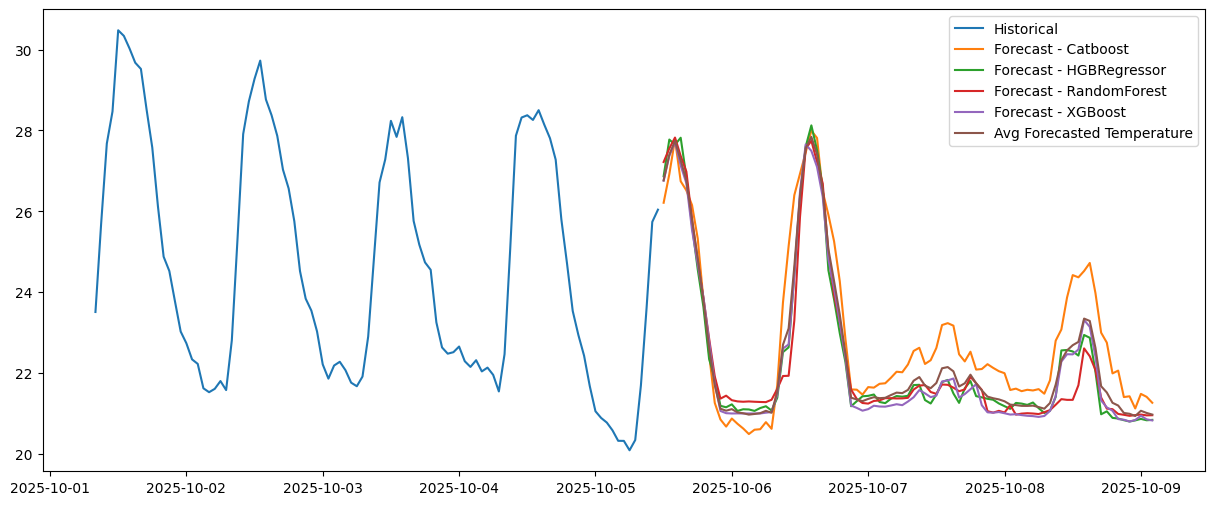

In [27]:
## plot predictions
plt.figure(figsize=(15,6))
plt.plot(all_data["timestamp"].tail(100),all_data["temperature"].tail(100),label = "Historical")
plt.plot(results_df["timestamp"],results_df["predicted_temperature"],label = "Forecast - Catboost")
plt.plot(results_df_hgb["timestamp"],results_df_hgb["predicted_temperature"],label = "Forecast - HGBRegressor")
plt.plot(results_df_rf["timestamp"],results_df_rf["predicted_temperature"],label = "Forecast - RandomForest")
plt.plot(results_df_xgb["timestamp"],results_df_xgb["predicted_temperature"],label = "Forecast - XGBoost")
plt.plot(results_df_avg["timestamp"],results_df_avg["predicted_temperature"],label = "Avg Forecasted Temperature")
plt.legend()
plt.show()

In [29]:
## Database insert
results_df["model"] = "Catboost"
results_df_hgb["model"] = "HistGradientBoosting"
results_df_rf["model"] = "RandomForest"
results_df_xgb["model"] = "XGBoost"
results_df_avg["model"] = "AVGForecast"
all_pred = pd.concat([results_df, results_df_hgb,results_df_rf,results_df_xgb,results_df_avg], axis=0)
all_pred["device_id"] = "1"
all_pred.columns = ["predicted_temperature", "forecast_datetime", "model", "device_id"]

##
execute_values(conn=connection, df=all_pred[['model','forecast_datetime','predicted_temperature','device_id']], table='public.predictions')

the dataframe is inserted


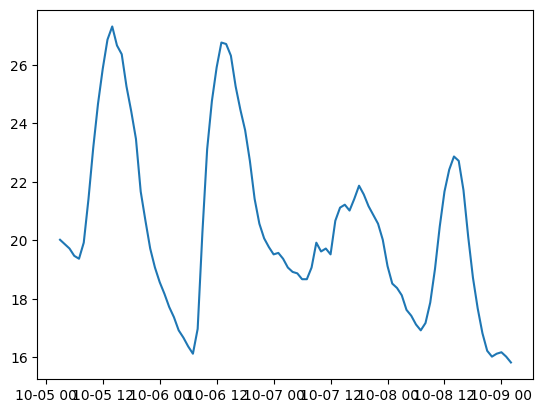

In [35]:
f = weather_api.fetch_weather_data(lat = lat,lon = lon,start_date=start,end_date=end)
f['timestamp'] = pd.to_datetime(f['timestamp']) + pd.Timedelta(hours=3)
plt.plot(f["timestamp"],f["temperature"])
plt.show()